In [1]:
import os
import cv2
import random
import math
import PIL.Image as Image
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence
import scipy.ndimage as ndi
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<!DOCTYPE html>
<html>

<body>

<h1><center>Iris Biometric Identification</h1> 
<h3><center>Vasil Kichukov</center></h3>


</body>
</html>

## Abstract


__What is Iris Biometric Identification?__

Iris biometric identification uses the unique patterns in the colored part of the eye (the iris) to identify individuals. Even the left and right irises of a person are unique. This method is highly secure and reliable, as no two people have the same iris patterns, making it one of the most accurate forms of biometric identification.

__Why is This Project Important?__

This project is important because iris recognition provides one of the most accurate ways to identify people. By developing a system that can segment the iris from the surrounding eye region, we can make the recognition process more precise and faster, which is crucial for secure applications.

__How Can This Be Used in Business?__

Iris recognition can be used in various industries for secure access, identity verification, and fraud prevention. It can improve security for businesses, banking, healthcare, and even in mobile devices, allowing for seamless and secure user experiences.

__What is the Purpose of This Project?__

The purpose of this project is to create a reliable system for accurately segmenting the iris from the eye using deep learning techniques. After segmentation, the project also focuses on recognizing the individual by comparing their segmented iris patterns to a database, allowing for secure identification and authentication. This process is essential for ensuring that the model can not only isolate the iris but also verify the identity of the person, which is crucial for applications like access control and secure transactions.

## Table of Contents

* [Dataset Representation](#Dataset-Representation)
* [IITD dataset](#IITD-dataset)
    * [Reading and Visualizations](#Reading-and-Visualizations)
    * [Iris Segmentation](#Iris-Segmentation)
        * [U-net Model](#U-net-Model)
        * [U-net Paper](#U-net-Paper)
* [CASIA dataset](#CASIA-dataset)
    * [Reading and Visualization](#Reading-and-Visualization)
    * [Pupil Detection - Iris Inner Boundary](#Pupil-Detection---Iris-Inner-Boundary) 
        * [VCF model](#VCF-model)
    * [Iris Recognition](#Iris-Recognition)
        * [Data preparation](#Data-preparation)
            * [Crop Images](#Crop-Images)
            * [Generate Masks](#Generate-Masks)
        * [Preprocessing](#Preprocessing)
        * [ResNet Model](#ResNet-Model)
        * [ResNet Model with Mask](#ResNet-Model-with-Mask)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

Iris biometric identification offers one of the most secure and accurate methods of recognizing individuals, as each person’s iris patterns are unique. Unlike other biometric traits, the iris remains stable throughout life and is extremely difficult to replicate, making it ideal for high-security applications such as banking, government, and healthcare.


Iris recognition systems are increasingly integrated into various sectors, from border control to mobile devices. These systems are growing in use due to their high accuracy and reliability. However, challenges like accurate segmentation of the iris, varying lighting conditions, and different eye shapes remain, which complicate large-scale deployment. With advancements in AI and machine learning, iris recognition technology is expected to improve in both speed and accuracy. As security needs continue to rise, iris biometric systems will likely play a critical role in personal identification and secure access in the future.

## Dataset Representation

The datasets used in this project are __IITD__ and __CASIA 1000__, which provide a rich collection of iris images for biometric identification tasks.

The __IITD dataset__ (Indian Eye Iris Dataset) was developed by the Indian Institute of Technology Delhi (IITD). It contains a total of __2240 RGB iris images__ collected from 224 individuals, with 10 images per subject. Each image in the dataset is of the size __320x240 pixels__, maintaining an __aspect ratio of 4:3__. The corresponding masks for this dataset, which are used for iris segmentation, were obtained from a GitHub repository, and I would like to express my gratitude to the creators of IITD for providing the images and permission to use them for my research purposes. The images are initially in RGB format, but for this project, I converted them to grayscale to simplify processing.

The __CASIA 1000__ dataset was downloaded from Kaggle and is another significant resource for iris recognition. It contains __20,000 grayscale iris images__ from 1000 subjects, with each subject contributing 20 images — 10 images from their left eye and 10 from their right eye. The images in this dataset have a resolution of __640x480 pixels__, with an __aspect ratio of 4:3__. The CASIA 1000 dataset offers a diverse set of iris images that will be invaluable for testing and validating the segmentation and recognition models.

While the images in IITD are of smaller resolution, CASIA 1000 offers a larger and more varied collection, ensuring robust model training and evaluation. The IITD dataset is primarily used in this project to create segmentation masks for the main CASIA dataset, enabling effective segmentation of the irises from the CASIA images. These segmentation masks will be crucial in training the models for iris recognition, ensuring high accuracy and reliability in real-world applications. Both datasets play a critical role in this project, enabling the development and testing of advanced segmentation and recognition algorithms for biometric iris identification.

# IITD dataset

In [2]:
BASE_IMAGE_DIR = "data_masks/IITD_dataset"
BASE_MASK_DIR  = "data_masks/IITD_masks"
SAVE_DIR = "./data"
HEIGHT = 240
WIDTH = 320
CHANNELS = 1
ASPECT_RATIO = WIDTH/HEIGHT
SIZE = (WIDTH, HEIGHT)
SIZE_CHANNELS = (WIDTH, HEIGHT, CHANNELS)
BATCH_SIZE = 16
EPOCHS = 32

To reduce hardcoding, we'll keep everything in different variables so we can manipulate it more easily if needed.

## Reading and Visualizations

In [3]:
def check_image_dimensions_dir(directory, expected_size, expected_channels):
    incorrect_dimensions = []
    
    if expected_channels == 1:
        expected_mode = 'L'
    elif expected_channels == 3:
        expected_mode = 'RGB'
    else:
        expected_mode = None
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.bmp', '.tiff',)):
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        actual_size = img.size
                        actual_mode = img.mode
                        if actual_size != expected_size or (expected_mode and actual_mode != expected_mode):
                            incorrect_dimensions.append((image_path, actual_size, actual_mode))
                except Exception as e:
                    incorrect_dimensions.append((image_path, "Error", str(e)))
                    
    if incorrect_dimensions:
        print(f"{len(incorrect_dimensions)} images with incorrect dimensions {directory}.")
        for i, (file_path, size, mode) in enumerate(incorrect_dimensions[:4]):
            print(f"{file_path} -> size: {size}, mode: {mode}")
    else:
        print(f"All images in {directory} have correct dimensions and mode.")

print("Checking BASE_IMAGE_DIR:")
check_image_dimensions_dir(BASE_IMAGE_DIR, expected_size=SIZE, expected_channels=CHANNELS)
print("\nChecking BASE_MASK_DIR:")
check_image_dimensions_dir(BASE_MASK_DIR, expected_size=SIZE, expected_channels=CHANNELS)

Checking BASE_IMAGE_DIR:
2240 images with incorrect dimensions data_masks/IITD_dataset.
data_masks/IITD_dataset\001\01.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\02.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\03.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\04.bmp -> size: (320, 240), mode: RGB

Checking BASE_MASK_DIR:
All images in data_masks/IITD_masks have correct dimensions and mode.


This function checks that all images in the specified directories have the right size and color mode. It reports any images that do not match, and in this case, it shows that the base images are in RGB format, which we will change to grayscale in the preprocessing step.

In [4]:
def map_images_to_masks(BASE_IMAGE_DIR, BASE_MASK_DIR):
    image_to_mask_map = {}

    for folder_id in range(1, 225):
        folder_str = f"{folder_id:03d}"
        image_folder_path = os.path.join(BASE_IMAGE_DIR, folder_str)
        
        for i in range(1, 11):
            image_index_str = f"{i:02d}"
            image_filename = f"{image_index_str}.bmp"
            full_image_path = os.path.join(image_folder_path, image_filename)
            mask_filename = f"{folder_str}_{image_index_str}.tiff"
            full_mask_path = os.path.join(BASE_MASK_DIR, mask_filename)
            
            if os.path.exists(full_image_path) and os.path.exists(full_mask_path):
                image_to_mask_map[full_image_path] = full_mask_path
            else:
                print(f"Missing file(s): {full_image_path} or {full_mask_path}")
    
    return image_to_mask_map

image_to_mask_map = map_images_to_masks(BASE_IMAGE_DIR, BASE_MASK_DIR)


print("\nFirst 5 (image -> mask) pairs:")
for idx, (img_path, mask_path) in enumerate(image_to_mask_map.items()):
    print(f"{idx+1}. {img_path} -> {mask_path}")
    if idx == 4:
        break


First 5 (image -> mask) pairs:
1. data_masks/IITD_dataset\001\01.bmp -> data_masks/IITD_masks\001_01.tiff
2. data_masks/IITD_dataset\001\02.bmp -> data_masks/IITD_masks\001_02.tiff
3. data_masks/IITD_dataset\001\03.bmp -> data_masks/IITD_masks\001_03.tiff
4. data_masks/IITD_dataset\001\04.bmp -> data_masks/IITD_masks\001_04.tiff
5. data_masks/IITD_dataset\001\05.bmp -> data_masks/IITD_masks\001_05.tiff


Here we are matching images in the BASE_IMAGE_DIR with their corresponding mask files in BASE_MASK_DIR, creating a dictionary with image paths as keys and mask paths as values. It prints the first five matches for inspection.

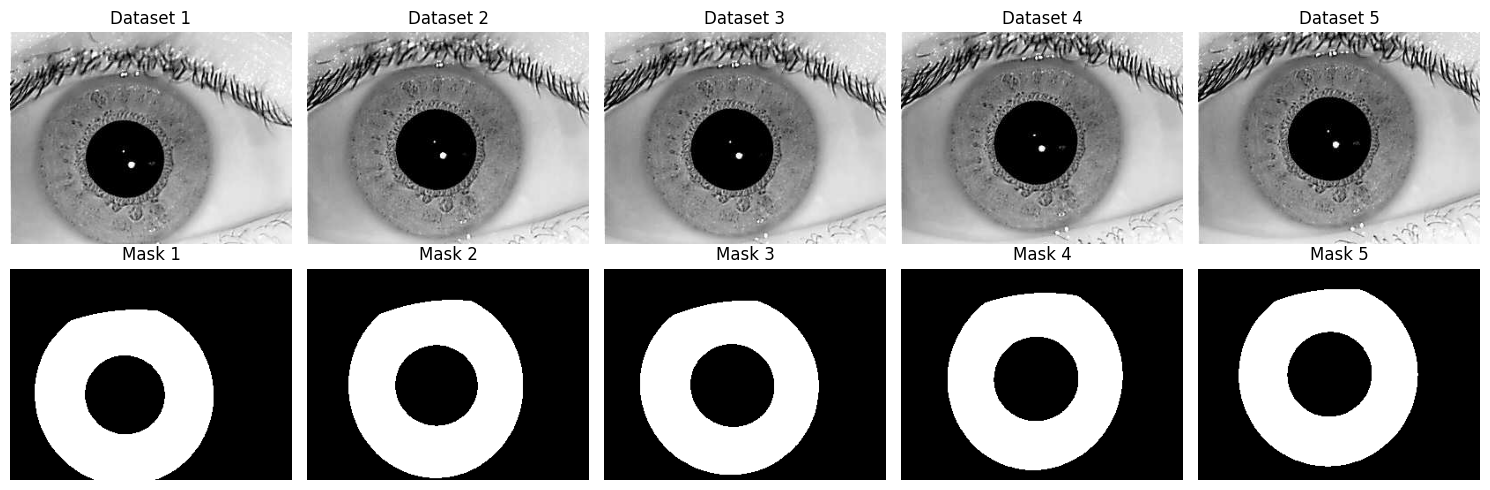

In [5]:
def visualize_images_from_dict(image_to_mask_map, num_images=5):
    selected_pairs = list(image_to_mask_map.items())[:num_images]
    plt.figure(figsize=(15, 5))  
    
    for i, (img_path, mask_path) in enumerate(selected_pairs):
        img = Image.open(img_path)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Dataset {i+1}")
        plt.axis('off')
        
        mask_img = Image.open(mask_path)
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(mask_img, cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_from_dict(image_to_mask_map, num_images=5)

## Iris Segmentation

In [6]:
def split_dataset(image_to_mask_map, train_ratio=0.8):
    pairs = list(image_to_mask_map.items())
    random.shuffle(pairs)
    split_idx = int(train_ratio * len(pairs))
    
    train_pairs = pairs[:split_idx]
    val_pairs   = pairs[split_idx:]
    
    return train_pairs, val_pairs

train_pairs, val_pairs = split_dataset(image_to_mask_map, train_ratio=0.8)

print(f"Train pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")

Train pairs: 1792
Validation pairs: 448


We split the dataset of image-mask pairs into training and validation sets based on the specified train_ratio. It first shuffles the image-mask pairs to ensure a random split, then divides the shuffled pairs into two sets: one for training and the other for validation. The training set contains train_ratio (default 80%) of the total pairs, and the remaining pairs are allocated to the validation set.

In [10]:
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

The Dice coefficient is used for segmentation because it effectively measures the overlap between the predicted mask and the ground truth mask. Unlike accuracy, which can be misleading in cases of imbalanced datasets, the Dice coefficient focuses on how well the model captures the iris area by comparing the true positive pixels in both the predicted and actual masks.

In [11]:
def get_early_stopping_callback():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=2, 
        restore_best_weights=True
    )

EarlyStopping callback monitors the validation loss during training. If the validation loss doesn't improve for 2 consecutive epochs (patience=2), training stops early and the best model weights are restored.

### U-net Model

In [7]:
def load_image_mask(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    img_norm = img.astype(np.float32) / 255.0
    msk_bin = (msk > 127).astype(np.float32)
    
    img_norm = np.expand_dims(img_norm, axis=-1)
    msk_bin  = np.expand_dims(msk_bin, axis=-1)
    
    return img_norm, msk_bin

The function loads an image and its corresponding mask from the specified file paths. Although the image files are originally in RGB format, the function reads them as grayscale using OpenCV. The image is then normalized to the range [0, 1] by dividing its pixel values by 255, and the mask is binarized by setting pixels above a threshold of 127 to 1 and below to 0. After processing, both the image and the mask are expanded to have an extra dimension (making them 3D arrays, i.e., (height, width, 1)) to match the input shape required by the model. 

In [8]:
def augment_image_mask(img, msk):
    if random.random() < 0.1:
        img = tf.image.flip_left_right(img)
        msk = tf.image.flip_left_right(msk)

    if random.random() < 0.1:
        img = tf.image.flip_up_down(img)
        msk = tf.image.flip_up_down(msk)
    
    if random.random() < 0.1:
        img = tf.image.random_brightness(img, max_delta=0.2)
    
    if random.random() < 0.1:
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.05)
        img = img + noise
        img = tf.clip_by_value(img, 0.0, 1.0)
    
    if random.random() < 0.5:
        img_np = img.numpy()
        img_np = np.squeeze(img_np, axis=-1)
        ksize = random.choice([3, 5])
        img_np = cv2.GaussianBlur(img_np, (ksize, ksize), 0)
        img_np = np.expand_dims(img_np, axis=-1)
        img = tf.convert_to_tensor(img_np, dtype=tf.float32)
    
    return img, msk

This function applies various augmentations to images and their masks, such as flipping, brightness changes, adding noise, and blurring. These techniques were selected based on experiments that found they provided the best performance and helped reduce overfitting in the model.

In [9]:
def data_generator(pairs_list, batch_size=8, augment=False):
    while True:
        random.shuffle(pairs_list)
        for i in range(0, len(pairs_list), batch_size):
            batch_pairs = pairs_list[i:i+batch_size]
            images = []
            masks = []
            
            for (img_path, msk_path) in batch_pairs:
                img_arr, msk_arr = load_image_mask(img_path, msk_path)
                img_tensor = tf.convert_to_tensor(img_arr, dtype=tf.float32)
                msk_tensor = tf.convert_to_tensor(msk_arr, dtype=tf.float32)
                
                if augment:
                    img_tensor, msk_tensor = augment_image_mask(img_tensor, msk_tensor)
                
                images.append(img_tensor.numpy())
                masks.append(msk_tensor.numpy())
            
            images = np.array(images, dtype=np.float32)
            masks  = np.array(masks,  dtype=np.float32)
            
            yield images, masks

Generator yields batches of image-mask pairs for training a model. It continuously loops through the provided list of image-mask pairs (pairs_list), shuffles them, and splits them into batches of a specified size (batch_size). For each batch, it loads the corresponding images and masks using the load_image_mask function, processes them into grayscale format, normalizes the images, and binarizes the masks. The function yields these batches of processed images and masks indefinitely for training.

In [12]:
def create_unet(input_shape=(240,320,1), dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    d1 = layers.Dropout(dropout_rate)(c1)
    p1 = layers.MaxPooling2D((2,2))(d1)

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    d2 = layers.Dropout(dropout_rate)(c2)
    p2 = layers.MaxPooling2D((2,2))(d2)

    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c3)
    d3 = layers.Dropout(dropout_rate)(c3)
    p3 = layers.MaxPooling2D((2,2))(d3)

    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c4)
    d4 = layers.Dropout(dropout_rate)(c4)
    p4 = layers.MaxPooling2D((2,2))(d4)

    c5 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(512, (3,3), activation='relu', padding='same')(c5)
    d5 = layers.Dropout(dropout_rate)(c5)

    u6 = layers.UpSampling2D((2,2))(d5)
    concat6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(concat6)
    c6 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2,2))(c6)
    concat7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(concat7)
    c7 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D((2,2))(c7)
    concat8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(concat8)
    c8 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D((2,2))(c8)
    concat9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(concat9)
    c9 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

The __U-Net architecture__ is a popular model for image segmentation tasks. It consists of two main parts: downsampling (contracting path) and upsampling (expansive path).

__Downsampling__ (Contracting Path): This part extracts features from the input image using convolutional layers with ReLU activation and max-pooling layers for downsampling. It captures spatial hierarchies of the image.

The first convolution block (c1) has two convolutional layers with 32 filters, followed by a max-pooling operation.

The second block (c2) uses 64 filters and also follows the same pattern.

The third block (c3) has 128 filters and serves as the bottleneck of the network, where the most abstract features are captured.

__Upsampling__ (Expansive Path): This part rebuilds the segmented output using up-sampling layers followed by convolutions. It combines the features from earlier layers using skip connections (concatenation) to preserve high-resolution details. U4 and u5 are upsampling layers, each followed by convolution blocks (c4, c5) to refine the segmentation.

Output Layer: The final layer produces a single channel output (grayscale), using a sigmoid activation for pixel-wise classification (foreground or background). The sigmoid activation ensures that the model outputs a probability map, where values closer to 1 represent foreground (iris) and values closer to 0 represent the background.

In [13]:
train_gen = data_generator(train_pairs, batch_size=BATCH_SIZE, augment=True)
val_gen   = data_generator(val_pairs, batch_size=BATCH_SIZE, augment=False)

model_unet = create_unet(input_shape=(240, 320, 1), dropout_rate=0.2)
model_unet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[dice_metric])

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 320, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 240, 320, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 240, 320, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 240, 320, 32)         0         ['conv2d_1[0][0]']            
                                                                                              

The model is compiled using the Adam optimizer, which adapts the learning rate based on training, and the binary cross-entropy loss function, suitable for binary segmentation tasks (iris vs. background).

In [14]:
steps_per_epoch  = len(train_pairs) // BATCH_SIZE
validation_steps = len(val_pairs)   // BATCH_SIZE

history_unet = model_unet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=len(train_pairs) // BATCH_SIZE,
    validation_steps=len(val_pairs) // BATCH_SIZE,
    callbacks=[get_early_stopping_callback()]
)

Epoch 1/32
112/112 [==============================] - 776s 7s/step - loss: 0.3298 - dice_metric: 0.6411 - val_loss: 0.5877 - val_dice_metric: 0.2871
Epoch 2/32
112/112 [==============================] - 765s 7s/step - loss: 0.1299 - dice_metric: 0.8730 - val_loss: 0.8388 - val_dice_metric: 0.2353
Epoch 3/32
112/112 [==============================] - 768s 7s/step - loss: 0.0813 - dice_metric: 0.9210 - val_loss: 0.2476 - val_dice_metric: 0.8333
Epoch 4/32
112/112 [==============================] - 771s 7s/step - loss: 0.0572 - dice_metric: 0.9434 - val_loss: 0.0895 - val_dice_metric: 0.9160
Epoch 5/32
112/112 [==============================] - 768s 7s/step - loss: 0.0499 - dice_metric: 0.9503 - val_loss: 0.0742 - val_dice_metric: 0.9206
Epoch 6/32
112/112 [==============================] - 772s 7s/step - loss: 0.0458 - dice_metric: 0.9546 - val_loss: 0.0733 - val_dice_metric: 0.9183
Epoch 7/32
112/112 [==============================] - 762s 7s/step - loss: 0.0424 - dice_metric: 0.9579 - 

The training shows steady progress in both loss reduction and improvement in segmentation quality. The model is learning effectively on the training set while maintaining a good generalization to the validation set. 

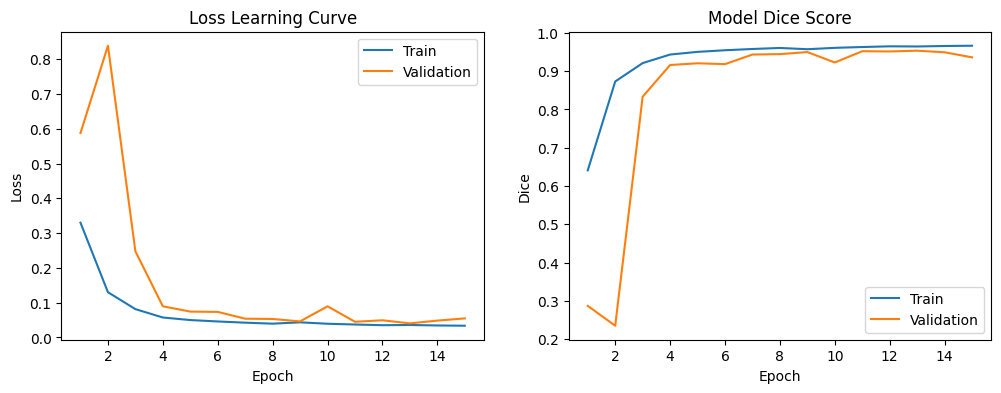

In [15]:
def plot_learning_curves(history_unet):
    train_loss = history_unet.history['loss']
    val_loss   = history_unet.history['val_loss']
    
    train_dice = history_unet.history['dice_metric']
    val_dice   = history_unet.history['val_dice_metric']
    
    epochs_range = range(1, len(train_loss)+1)
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Train')
    plt.plot(epochs_range, val_loss, label='Validation')
    plt.title('Loss Learning Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_dice, label='Train')
    plt.plot(epochs_range, val_dice, label='Validation')
    plt.title('Model Dice Score')
    plt.ylabel('Dice')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.show()
    
plot_learning_curves(history_unet)

__Loss Curve__: The training loss decreases steadily and levels off after about epoch 5, indicating the model is learning effectively. However, the validation loss begins to increase significantly from epoch 5 onwards, which might suggest the model is starting to overfit.

__Dice Score__: The training Dice score is increasing and becomes stable, which is expected. The validation Dice score follows a similar pattern, but it decreases slightly after reaching its peak around epoch 6-7. This is a clear sign of overfitting—while the model performs well on the training data, its performance on unseen data (validation data) starts to degrade.

__Epoch 10__: At this point, the validation Dice score starts to drop, and the validation loss starts to increase, which is a strong indicator of overfitting. Overfitting happens when the model becomes too specialized in learning the training data, rather than generalizing well to unseen data.

In [16]:
def create_overlay(original_path, pred_mask, alpha=0.4):
    pred_mask = pred_mask.squeeze(axis=-1)

    orig = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
    orig_color = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
    
    green_mask = np.zeros_like(orig_color)
    green_mask[...,1] = (pred_mask * 255).astype(np.uint8)

    overlay = cv2.addWeighted(orig_color, 1.0, green_mask, alpha, 0)
    return overlay

We create an image overlay where the predicted mask is displayed on top of the original image. It first reads the original image and converts it to a color format. Then, it creates a green mask from the predicted mask and overlays it on the original image with a specified transparency (alpha). The resulting image shows the original iris image with the predicted mask highlighted in green.

In [31]:
def evaluate_segmentation_per_image(pairs_list, model, threshold=0.5, dice_threshold=0.7):
    poorly_segmented = []
    target_height, target_width = model.input_shape[1:3]
    
    for (img_path, msk_path) in pairs_list:
        if target_height == target_width:
            img_arr, msk_arr = load_image_mask_paper(img_path, msk_path, target_size=target_height)
        else:
            img_arr, msk_arr = load_image_mask(img_path, msk_path)

        pred = model.predict(np.expand_dims(img_arr, axis=0), verbose=0)
        pred_2d = pred[0, ..., 0]  
        pred_bin = (pred_2d > threshold).astype(np.float32)

        y_true_f = msk_arr.flatten()
        y_pred_f = pred_bin.flatten()
        intersection = np.sum(y_true_f * y_pred_f)
        dice = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-6)

        if dice < dice_threshold:
            poorly_segmented.append((img_path, dice, pred_bin))

    if poorly_segmented:
        print(f"Found {len(poorly_segmented)} poorly segmented images (dice < {dice_threshold}):")
        for img_path, dice_val, pred_mask in poorly_segmented:
            print(f"{img_path} => dice={dice_val:.3f}")
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            pred_mask_for_overlay = cv2.resize(
                pred_mask, 
                (img.shape[1], img.shape[0]),
                interpolation=cv2.INTER_NEAREST
            )
            green_mask = np.zeros_like(img_color)
            green_mask[..., 1] = (pred_mask_for_overlay * 255).astype(np.uint8)
            overlay = cv2.addWeighted(img_color, 1.0, green_mask, 0.5, 0)
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(img_color, cmap='gray')
            plt.title(f"Original Image\nDice: {dice_val:.3f}")
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(overlay)
            plt.title("Mask Overlay")
            plt.axis('off')
            plt.show()
    else:
        print("All images have a higher score than the dice threshold.")

In [ ]:
poorly_segmented_images = evaluate_segmentation_per_image(val_pairs, model_unet, threshold=0.5, dice_threshold=0.70)

All images have a higher score than the dice threshold.

The function checks each image's Dice score. If the score is below the specified threshold (default 0.7), the image is considered poorly segmented. The function prints the image path, Dice score, and displays an overlay of the predicted mask on the original image for inspection.

In [18]:
os.makedirs(SAVE_DIR, exist_ok=True)
model_path = os.path.join(SAVE_DIR, "seg_model.h5")
model_unet.save(model_path)
print(f"The segmentation model has been successfully saved as 'seg_model.h5' in the folder '{SAVE_DIR}'.")

C:\Users\Gaming PC\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The segmentation model has been successfully saved as 'seg_model.h5' in the folder './data'.


### U-net Paper

The U-Net architecture, introduced by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in their 2015 paper "U-Net: Convolutional Networks for Biomedical Image Segmentation," is specifically designed for semantic segmentation tasks, particularly in biomedical image analysis.

In [19]:
SQARE_SIZE = 320
BATCH_SIZE = 8

In [20]:
def pad_image_to_square(image, target_size, pad_value=0):
    h, w = image.shape[:2]
    delta_w = target_size - w
    delta_h = target_size - h
    top = delta_h // 2
    bottom = delta_h - top
    left = delta_w // 2
    right = delta_w - left
    
    padded = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=pad_value)
    return padded

Padding is useful when you need all images in your dataset to have the same dimensions, especially when working with models that expect square-shaped input images, such as certain neural networks or image segmentation models. We are following the paper and reshaping the images and masks to square size 320.

In [21]:
def load_image_mask_paper(image_path, mask_path, target_size=SQARE_SIZE):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    img_padded = pad_image_to_square(img, target_size, pad_value=0)
    msk_padded = pad_image_to_square(msk, target_size, pad_value=0)
    
    img_norm = img_padded.astype(np.float32) / 255.0
    msk_bin  = (msk_padded > 127).astype(np.float32)
    
    img_norm = np.expand_dims(img_norm, axis=-1)
    msk_bin  = np.expand_dims(msk_bin, axis=-1)
    
    return img_norm, msk_bin

It prepares the data by making sure all images and masks are square and properly scaled, making them ready for feeding into the model. Useful in tasjks like image segmentation, where you need to load and preprocess images and their corresponding segmentation masks for training a model.

In [22]:
def augment_image_and_mask(img, msk):
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    msk_tensor = tf.convert_to_tensor(msk, dtype=tf.float32)
    
    if random.random() < 0.2:
        img_tensor = tf.image.flip_left_right(img_tensor)
        msk_tensor = tf.image.flip_left_right(msk_tensor)
    
    if random.random() < 0.2:
        img_tensor = tf.image.flip_up_down(img_tensor)
        msk_tensor = tf.image.flip_up_down(msk_tensor)
    
    if random.random() < 0.03:
        img_tensor = tf.image.random_brightness(img_tensor, max_delta=0.2)
    
    if random.random() < 0.3:
        noise = tf.random.normal(shape=tf.shape(img_tensor), mean=0.0, stddev=0.05)
        img_tensor = img_tensor + noise
        img_tensor = tf.clip_by_value(img_tensor, 0.0, 1.0)
    
    if random.random() < 0.5:
        img_np = img_tensor.numpy()
        img_np = np.squeeze(img_np, axis=-1)
        ksize = random.choice([3, 5])
        img_np = cv2.GaussianBlur(img_np, (ksize, ksize), 0)
        img_np = np.expand_dims(img_np, axis=-1)
        img_tensor = tf.convert_to_tensor(img_np, dtype=tf.float32)
    
    return img_tensor.numpy(), msk_tensor.numpy()

This function helps the model generalize better by presenting it with modified versions of the original images and masks. The increased chance of augmentation compensates for the lack of dropout and ensures that the model is exposed to a broader range of image variations, making it less likely to overfit to specific patterns in the training data.

In [23]:
def data_generator_paper(pairs_list, batch_size=BATCH_SIZE, augment=True):
    while True:
        random.shuffle(pairs_list)
        for i in range(0, len(pairs_list), batch_size):
            batch_pairs = pairs_list[i : i+batch_size]
            images = []
            masks  = []
            for (img_path, msk_path) in batch_pairs:
                img_arr, msk_arr = load_image_mask_paper(img_path, msk_path, target_size=SQARE_SIZE)
                
                if augment:
                    img_arr, msk_arr = augment_image_and_mask(img_arr, msk_arr)
                
                images.append(img_arr)
                masks.append(msk_arr)
            images = np.array(images, dtype=np.float32)
            masks  = np.array(masks, dtype=np.float32)
            yield images, masks

The data pipeline prepares the data for training in a way that ensures variability (through augmentation) and consistency (through batching and shuffling). It allows the model to be trained on different variations of the data each time, making it more robust.

In [24]:
class CropToMatch(layers.Layer):
    def call(self, inputs):
        source, target = inputs
        s = tf.shape(source)
        t = tf.shape(target)

        height_diff = s[1] - t[1]
        width_diff  = s[2] - t[2]

        crop_top  = height_diff // 2
        crop_left = width_diff  // 2

        return tf.slice(
            source,
            [0, crop_top, crop_left, 0],
            [-1, s[1] - crop_top*2, s[2] - crop_left*2, -1]
        )

The CropToMatch layer crops a source image to match the size of a target image, keeping the batch size and channels the same. It helps ensure that images can be processed together in the same shape within a model, such as in a U-Net architecture.

In [25]:
def unet_paper(input_shape=(SQARE_SIZE, SQARE_SIZE, 1), num_classes=1, initial_filters=64, final_activation='sigmoid'):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    c5 = layers.Conv2D(initial_filters*16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = layers.Conv2D(initial_filters*16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    u6 = layers.Conv2DTranspose(initial_filters*8, (2,2), strides=2, kernel_initializer='he_normal')(c5)
    merge6 = layers.concatenate([u6, c4], axis=-1)
    c6 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    c6 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    u7 = layers.Conv2DTranspose(initial_filters*4, (2,2), strides=2, kernel_initializer='he_normal')(c6)
    merge7 = layers.concatenate([u7, c3], axis=-1)
    c7 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    c7 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    u8 = layers.Conv2DTranspose(initial_filters*2, (2,2), strides=2, kernel_initializer='he_normal')(c7)
    merge8 = layers.concatenate([u8, c2], axis=-1)
    c8 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    c8 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

    u9 = layers.Conv2DTranspose(initial_filters, (2,2), strides=2, kernel_initializer='he_normal')(c8)
    merge9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    c9 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

    outputs = layers.Conv2D(num_classes, (1,1), activation=final_activation)(c9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

The __U-Net architecture__ is a powerful deep learning model designed for image segmentation tasks, particularly in biomedical imaging. It is structured with two main parts: 

__Downsampling__:
The contracting path captures important features of the input image by progressively reducing the spatial dimensions. This is done through convolutional layers that extract spatial hierarchies followed by max-pooling layers that downsample the feature maps.

_Block 1 (c1)_: The first block consists of two convolutional layers, each using 64 filters, followed by a max-pooling operation to reduce the feature map size.

_Block 2 (c2)_: Similar to block 1, but with 128 filters. It continues extracting more complex features.

_Block 3 (c3)_: The bottleneck block with 256 filters, capturing the most abstract and high-level features of the image. This block represents the deepest point of the network, where the feature maps are compressed to their smallest form.


__Upsampling__:
The expansive path aims to rebuild the image from the compressed features by progressively increasing the spatial dimensions. This is done using deconvolutional layers (also called transposed convolutions) and skip connections, which concatenate features from earlier layers to retain high-resolution details.

_Up-sampling Block 1 (u6)_: This block upsamples the feature map from the bottleneck and merges it with the features from the corresponding downsampling block (c4).

_Up-sampling Block 2 (u7)_: Upsamples again, merging with block 3’s features.

_Up-sampling Block 3 (u8)_: Continues the upsampling process and merges with block 2’s features.

_Up-sampling Block 4 (u9)_: Final upsampling block that restores the image size, merging with the first downsampling block (c1).

Output Layer:
The output layer of the U-Net generates a final segmentation map. The network uses a 1x1 convolution to map the output to a single channel (grayscale image). A sigmoid activation function is used to classify each pixel as either belonging to the foreground (the object of interest, e.g., iris) or the background. The output of this layer is a probability map, with values close to 1 representing the foreground (iris) and values close to 0 representing the background.

In [26]:
def train_unet_paper(
    train_pairs, val_pairs,
    steps_per_epoch, validation_steps,
    epochs=EPOCHS,
    optimizer_params=None,
    num_classes=1,
    final_activation='sigmoid',
    loss='binary_crossentropy',
    metrics=None,
    plot_model_diagram=False
):
    if metrics is None:
        metrics = [dice_metric]

    model = unet_paper(
        input_shape=(SQARE_SIZE, SQARE_SIZE, 1),
        num_classes=num_classes,
        final_activation=final_activation
    )
    
    print("---- Model Summary ----")
    model.summary()

    if plot_model_diagram:
        tf.keras.utils.plot_model(
            model,
            to_file='unet_architecture.png',
            show_shapes=True,
            show_layer_names=True
        )
        print("Model diagram saved as 'unet_architecture.png'")

    if optimizer_params is None:
        optimizer_params = {'learning_rate':1e-4}
    optimizer = tf.keras.optimizers.Adam(**optimizer_params)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    train_gen = data_generator_paper(train_pairs, batch_size=BATCH_SIZE, augment=True)
    val_gen   = data_generator_paper(val_pairs, batch_size=BATCH_SIZE, augment=False)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[get_early_stopping_callback()]
    )

    return model, history

The Adam optimizer is an efficient optimization algorithm that adapts the learning rate for each parameter, helping the model converge faster. It combines the benefits of momentum and RMSProp. The learning rate of 1e-4 is set, meaning small adjustments are made to the model weights during training, preventing drastic changes that could destabilize the learning process.

In [27]:
STEPS_PER_EPOCH_PAPER  = len(train_pairs) // BATCH_SIZE
VALIDATION_STEPS_PAPER = len(val_pairs)   // BATCH_SIZE

model_paper, history_paper = train_unet_paper(
    train_pairs, val_pairs,
    steps_per_epoch=STEPS_PER_EPOCH_PAPER,
    validation_steps=VALIDATION_STEPS_PAPER,
    epochs=EPOCHS,
    optimizer_params={'learning_rate':1e-4},
    num_classes=1,
    final_activation='sigmoid',
    loss='binary_crossentropy',
    metrics=[dice_metric],
    plot_model_diagram=False
)

---- Model Summary ----
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 320, 320, 64)         640       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 320, 320, 64)         36928     ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 160, 160, 64)         0         ['conv2d_20[0][0]']           
 g2D)                                                               

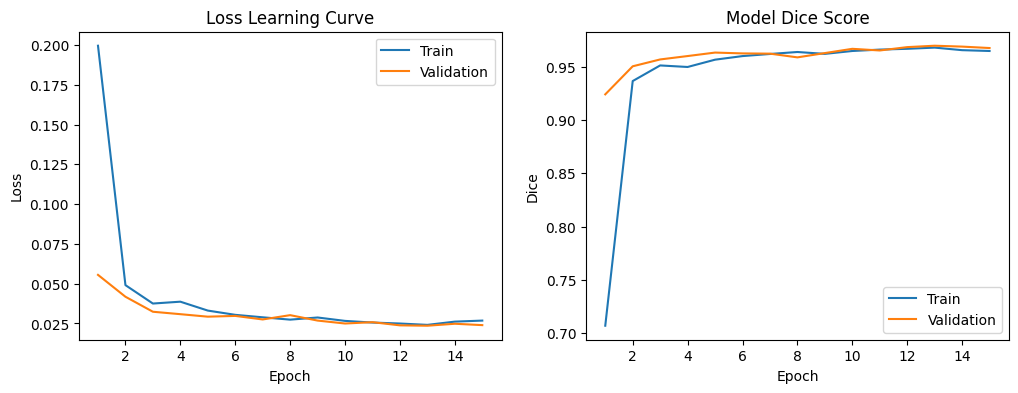

In [28]:
plot_learning_curves(history_paper)

__Loss Curve__: The loss training decreases rapidly from the start of the training, indicating that the model is learning quickly in the initial epochs. The validation loss also drops significantly but seems to flatten after epoch 3. This is a good sign because the model is not overfitting to the validation data, and the loss remains low even on unseen data.

__Dice Score__: The training Dice score increases steadily, showing that the model's performance on training data improves as expected. The validation Dice score also increases but at a slightly slower rate than training, which is typical in deep learning. The fact that the validation curve is close to the training curve means that the model is generalizing well and not overfitting.

__Model Stability__: There are no significant signs of overfitting here. Both the training and validation curves are converging towards an optimal value, with a stable Dice score around 0.95. The training and validation losses are quite close, which suggests that the model is well-regularized.

In [32]:
poorly_segmented_images = evaluate_segmentation_per_image(val_pairs, model_paper, threshold=0.5, dice_threshold=0.70)

All images have a higher score than the dice threshold.


In [33]:
os.makedirs(SAVE_DIR, exist_ok=True)
model_paper_path = os.path.join(SAVE_DIR, "seg_model_paper.h5")
model_paper.save(model_paper_path)
print(f"The second segmentation model has been saved as 'seg_model_paper.h5' in the folder '{SAVE_DIR}'.")

The second segmentation model has been saved as 'seg_model_paper.h5' in the folder './data'.


# CASIA dataset

In [76]:
CSV_FILE = "./data/iris_thousands.csv"
PUPIL_DATASET_DIR = ".//data/pupil_dataset"
PUPIL_PRED_DATASET_DIR = ".//data/pupil_dataset_pred"
WORK_DATASET_DIR = ".//data/work_dataset"
MASK_DATASET_DIR = "./data/mask_dataset/"
SEG_MODEL = "./data/seg_model_paper.h5"
ORIGINAL_CASIA_DIR = "./data/CASIA-Iris-Thousand/"
NUM_CLASSES = 2000
IMAGE_WIDTH = 640    
IMAGE_HEIGHT = 480
IMAGE_CHANNELS = 1
TARGET_SIZE = (320, 240)
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SIZE_CHANNELS = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 24

## Reading and Visualization

In [36]:
iris_data = pd.read_csv(CSV_FILE)
check_image_dimensions_dir(ORIGINAL_CASIA_DIR, expected_size=IMAGE_SIZE, expected_channels=IMAGE_CHANNELS)

All images in ./data/CASIA-Iris-Thousand/ have correct dimensions and mode.


This function checks if all images in the CASIA dataset have the correct size (320x240) and are grayscale. It confirms that the images are ready for processing, with no issues found.

In [37]:
def check_class_distribution(dataset):
    class_counts = dataset['Label'].value_counts()
    if class_counts.min() != class_counts.max():
        print("Class distribution is imbalanced.")
    else:
        print("Class distribution is balanced.")

check_class_distribution(iris_data)

Class distribution is balanced.


In [38]:
def update_paths(iris_df, base_dir, target_column):
    corrected_paths = []
    missing_files = []

    for index, row in iris_df.iterrows():
        label = row['Label']
        image_filename = os.path.basename(row['ImagePath'])
        subject_id, eye = label.split("-")

        corrected_path = os.path.join(base_dir, subject_id, eye, image_filename)

        if not os.path.exists(corrected_path):
            alternative_ext = ".bmp" if image_filename.lower().endswith(".jpg") else ".jpg"
            corrected_path_alt = os.path.splitext(corrected_path)[0] + alternative_ext

            if os.path.exists(corrected_path_alt):
                corrected_path = corrected_path_alt
            else:
                missing_files.append(corrected_path)

        corrected_paths.append(corrected_path)

    iris_df[target_column] = corrected_paths

    if not missing_files:
        print("All image paths are exist in the dataset")
    else:
        print(f"{len(missing_files)} missing image(s) found:")
        for file in missing_files[:5]:
            print(file)

    return iris_df 

Updating the image paths in iris_data to match the official CASIA 1000 dataset structure. The corrected paths are added to the OriginalPath column, and unnecessary columns are removed. This ensures that the dataset correctly points to the official images.

In [39]:
iris_data = update_paths(iris_data, ORIGINAL_CASIA_DIR, "OriginalPath")
iris_data = iris_data.drop(columns=["Unnamed: 0", "ImagePath"])
iris_data.head(4)

All image paths are exist in the dataset


Label                                   OriginalPath
0  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg
1  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg
2  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg
3  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R02.jpg

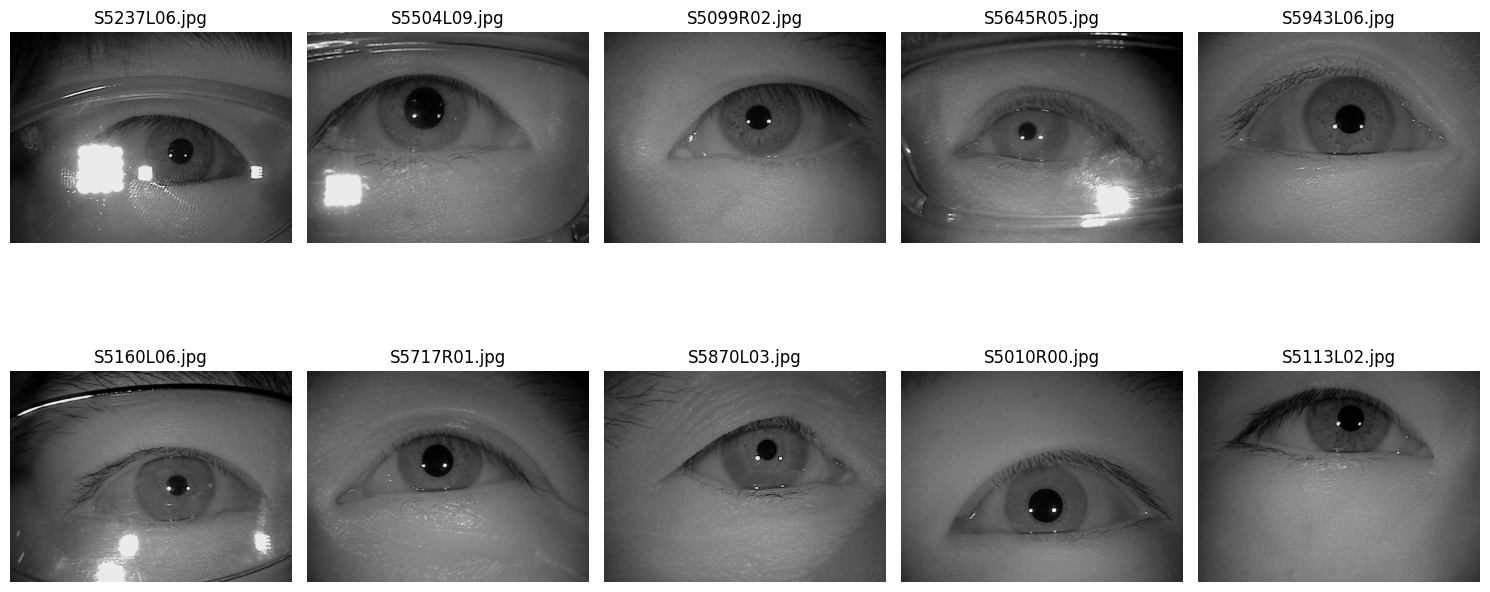

In [40]:
def visualize_images(dataset, column_name, num_images):
    sample_images = dataset.sample(num_images)[column_name].tolist()
    plt.figure(figsize=(15, 8))
    
    for i, image_path in enumerate(sample_images):
        img = Image.open(image_path)
        if IMAGE_CHANNELS == 1:
            img = img.convert("L")
        
        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img, cmap="gray" if IMAGE_CHANNELS == 1 else None)
        plt.title(os.path.basename(image_path))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_images(iris_data, "OriginalPath", num_images=10)

## Pupil Detection - Iris Inner Boundary

In [41]:
def refine_circle_by_intensity(image, circle, intensity_range, step=2):
    x, y, r = circle
    h, w = image.shape
    refined_r = r

    for i in range(-step, step + 1):
        temp_r = r + i
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, (x, y), temp_r, 1, thickness=1)
        band_pixels = image[mask == 1]

        if np.mean(band_pixels) >= intensity_range[0] and np.mean(band_pixels) <= intensity_range[1]:
            refined_r = temp_r
    return (x, y, refined_r)

Adjusts the radius of a detected pupil circle by checking the pixel intensity within the circle. It tests different radii within a specified range and selects the one where the average intensity falls within the given range. The function returns the refined circle with the best fitting radius.

In [42]:
def detect_pupil(image, param1=80, param2=30, min_radius=20, max_radius=80):
    gray = cv2.GaussianBlur(image, (7, 7), 0)
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=param1, param2=param2, 
        minRadius=min_radius, maxRadius=max_radius
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        x, y, r = circles[0, 0]
        refined_circle = refine_circle_by_intensity(gray, (x, y, r), intensity_range=(0, 70))
        return refined_circle
    return None

Detecting the pupil in an image using the Hough Circle Transform. It applies a Gaussian blur to the image and then uses cv2.HoughCircles to detect circles that may correspond to the pupil. If a circle is detected, the function refines the radius of the circle based on the pixel intensity inside the circle using the refine_circle_by_intensity function. The function returns the refined circle (x, y, r) if a pupil is detected, or None if no pupil is found.

In [43]:
def save_pupil_for_review(image, pupil_x, pupil_y, pupil_r, img_path):
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    cv2.circle(output_image, (pupil_x, pupil_y), pupil_r, (0, 255, 0), 2)
    cv2.circle(output_image, (pupil_x, pupil_y), 2, (0, 0, 255), 3)

    save_path = os.path.join(PUPIL_DATASET_DIR, os.path.basename(img_path))
    cv2.imwrite(save_path, output_image)

We save an image with the detected pupil highlighted. It first converts the grayscale image to color, then draws a green circle around the detected pupil and a red dot at the center. The image is saved in the pupil_dataset directory with the same name as the original image. This function is useful for reviewing and validating the accuracy of pupil detection results.

In [44]:
def detect_and_store_pupils(image_paths):
    for img_path in image_paths:
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        pupil = detect_pupil(image)
        if pupil is not None:
            pupil_x, pupil_y, pupil_r = pupil
            save_pupil_for_review(image, pupil_x, pupil_y, pupil_r, img_path)

    print(f"Pupil images saved in: {PUPIL_DATASET_DIR}")
    
os.makedirs(PUPIL_DATASET_DIR, exist_ok=True)
casia_jpg_paths = iris_data["OriginalPath"].tolist()
detect_and_store_pupils(casia_jpg_paths)

Pupil images saved in: .//data/pupil_dataset


All detected pupils are stored in the pupil_dataset folder and prepared for manual review. The algorithm detected 19,241(from 20,000) after manual inspection another 288 were deleted so in total our correctly segmented pupils are __18,953 or 94.75% of all images__.

In [45]:
def process_pupils():
    iris_data["PupilPath"] = ""  
    iris_data["pupil_x"] = None  
    iris_data["pupil_y"] = None  
    iris_data["pupil_radius"] = None 
    iris_data["pupil_detected"] = 0  

    for index, row in iris_data.iterrows():
        img_filename = os.path.basename(row["OriginalPath"])
        img_path = os.path.join(PUPIL_DATASET_DIR, img_filename)

        if os.path.exists(img_path): 
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            pupil = detect_pupil(image)

            if pupil is not None:
                pupil_x, pupil_y, pupil_r = pupil
                iris_data.at[index, "PupilPath"] = img_path
                iris_data.at[index, "pupil_detected"] = 1
                iris_data.at[index, "pupil_x"] = pupil_x
                iris_data.at[index, "pupil_y"] = pupil_y
                iris_data.at[index, "pupil_radius"] = pupil_r

    print(f"Iris dataset updated")

process_pupils()

Iris dataset updated


Checks if the pupil detection exists in the PUPIL_DATASET_DIR for each image. If the pupil is detected, it updates the dataset with the pupil's coordinates (pupil_x, pupil_y), radius (pupil_radius) and if the pupil was detected (pupil_detected)

In [46]:
iris_data.head(4)

Label                                   OriginalPath  \
0  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg   
1  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg   
2  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg   
3  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R02.jpg   

                            PupilPath pupil_x pupil_y pupil_radius  \
0                                        None    None         None   
1  .//data/pupil_dataset\S5437R09.jpg     308     168           38   
2  .//data/pupil_dataset\S5437R07.jpg     330     172           36   
3  .//data/pupil_dataset\S5437R02.jpg     336     246           32   

   pupil_detected  
0               0  
1               1  
2               1  
3               1

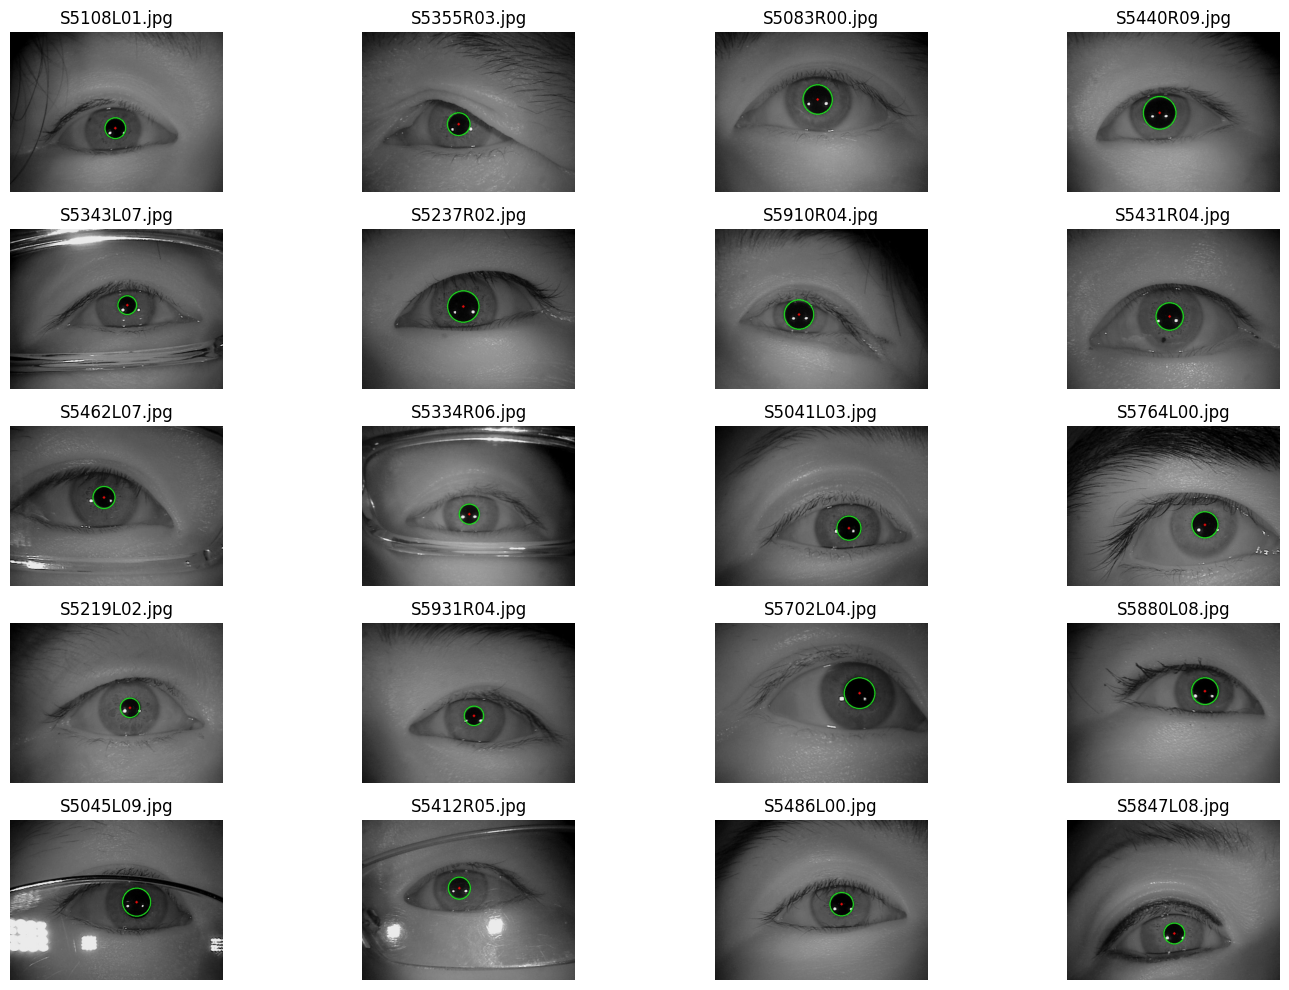

In [47]:
def visualize_pupils(directory, random_images=20):
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    if len(image_files) < random_images:
        sample_files = image_files
    else:
        sample_files = random.sample(image_files, random_images)
    
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(sample_files):
        try:
            img = Image.open(img_path)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue
        
        plt.subplot(5, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_pupils(PUPIL_DATASET_DIR, random_images=20)

### VCF model

In [6]:
PUPIL_EPOCH = 6
PUPIL_BATCH = 32
PUPIL_STEPS_PER_EPOCH = math.ceil(len(iris_data[iris_data['pupil_detected']==1])*0.85 / PUPIL_BATCH)
PUPIL_VALIDATION_STEPS = math.ceil(len(iris_data[iris_data['pupil_detected']==1])*0.15 / PUPIL_BATCH)
SAVE_PUPIL_MODEL = os.path.join(SAVE_DIR, "pupil_model.h5")

#Splitting the data into 85% for training and 15% for validation

The pupil implementation below is based on the paper "An integrated neural network model for pupil detection and tracking – Lu Shi, ChangYuan Wang, Feng Tian, Hongbo Jia". The proposed approach, referred to as the VCF model, combines two key components:

__V-Net__: A modified encoder–decoder network that extracts multi-scale features from the input image through successive downsampling and upsampling, with skip connections to retain fine details.

__CF (Coordinate-Final) Block__: Inspired by object detection methods like YOLO, this block divides the image into a grid and predicts the pupil parameters (x and y offsets, and radius) for the grid cell that contains the pupil center, along with a confidence score indicating responsibility.

In [48]:
def custom_pupil_loss(y_true, y_pred):
    x_true = y_true[..., 0]
    y_true_ = y_true[..., 1]
    r_true = y_true[..., 2]
    resp_true = y_true[..., 3]
    
    x_pred = y_pred[..., 0]
    y_pred_ = y_pred[..., 1]
    r_pred = y_pred[..., 2]
    conf_pred = y_pred[..., 3]
    
    lambda_coord = 5.0
    lambda_noobj = 0.5
    
    coord_loss = lambda_coord * resp_true * ((x_true - x_pred) ** 2 + (y_true_ - y_pred_) ** 2)
    radius_loss = lambda_coord * resp_true * ((r_true - r_pred) ** 2)
    
    conf_loss = resp_true * (1 - conf_pred) ** 2 + lambda_noobj * (1 - resp_true) * (conf_pred) ** 2
    
    total_loss = coord_loss + radius_loss + conf_loss
    return tf.reduce_mean(total_loss)

The custom loss function calculates the loss for pupil detection by comparing the true and predicted values for the pupil’s center coordinates, radius, and confidence. It applies a weighted loss depending on whether the cell is responsible for detecting the pupil or not. This helps the model focus on learning the correct position and size of the pupil, while also avoiding false positives. The total loss is a combination of the coordinate loss, radius loss, and confidence loss.

In [51]:
def pupil_data_generator(iris_data, batch_size=PUPIL_BATCH, image_size=(480, 640), grid_size=(7, 10), r_max=64, shuffle=True):
    df = iris_data[iris_data['pupil_detected'] == 1].copy().reset_index(drop=True)
    indices = np.arange(len(df))
    
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            batch_indices = indices[start:end]
            X_batch = []
            Y_batch = []
            
            grid_rows, grid_cols = grid_size
            img_h, img_w = image_size
            cell_h = img_h / grid_rows
            cell_w = img_w / grid_cols
            
            for i in batch_indices:
                row = df.iloc[i]
                img_path = row["OriginalPath"]
                image = cv2.imread(img_path)
                if image is None:
                    continue
                
                image = cv2.resize(image, (img_w, img_h))

                pupil_x = float(row['pupil_x'])
                pupil_y = float(row['pupil_y'])
                pupil_r = float(row['pupil_radius'])
                
                cell_row = int(pupil_y // cell_h)
                cell_col = int(pupil_x // cell_w)
                cell_row = min(cell_row, grid_rows - 1)
                cell_col = min(cell_col, grid_cols - 1)
                
                x_offset = (pupil_x - (cell_col * cell_w)) / cell_w
                y_offset = (pupil_y - (cell_row * cell_h)) / cell_h
                r_scaled = pupil_r / r_max

                target = np.zeros((grid_rows, grid_cols, 4), dtype=np.float32)
                target[cell_row, cell_col, :] = [x_offset, y_offset, r_scaled, 1.0]
                
                X_batch.append(image)
                Y_batch.append(target)
                            
            yield np.array(X_batch), np.array(Y_batch)

In [52]:
train_gen = pupil_data_generator(iris_data, batch_size=PUPIL_BATCH, image_size=(480, 640),
                                 grid_size=(7, 10), r_max=64, shuffle=True)
val_gen = pupil_data_generator(iris_data, batch_size=PUPIL_BATCH, image_size=(480, 640),
                               grid_size=(7, 10), r_max=64, shuffle=False)

We take a list of images and their pupil locations and generates batches for training the model. For each image, it divides the image into a grid and calculates where the pupil is located within that grid. It then generates a target grid with information about the pupil's position and radius. This allows the neural network to learn where the pupil is in each image. The function shuffles the data and processes it in batches for efficient training.

In [53]:
def center_mae_metric(y_true, y_pred):
    mask = y_true[..., 3:4]
    error = tf.abs(y_true[..., 0:2] - y_pred[..., 0:2])
    weighted_error = error * mask
    mae = tf.reduce_sum(weighted_error) / (tf.reduce_sum(mask) + 1e-6)
    return mae

This function calculates how far off the predicted pupil center coordinates (x, y) are from the true coordinates, but only for the cells where a pupil exists (indicated by the mask). The result is the MAE for the center prediction, showing how well the model is doing in detecting the pupil's position.

In [54]:
def radius_mae_metric(y_true, y_pred):
    mask = y_true[..., 3]
    error = tf.abs(y_true[..., 2] - y_pred[..., 2])
    weighted_error = error * mask
    mae = tf.reduce_sum(weighted_error) / (tf.reduce_sum(mask) + 1e-6)
    return mae

This function calculates the mean absolute error (MAE) between the predicted and actual pupil radius, but only for the cells where a pupil exists (indicated by the mask).

In [55]:
def euclidean_center_metric(y_true, y_pred):
    mask = y_true[..., 3:4]
    true_xy = y_true[..., 0:2] * mask
    pred_xy = y_pred[..., 0:2] * mask
    true_center = tf.reduce_sum(true_xy, axis=[1, 2])
    pred_center = tf.reduce_sum(pred_xy, axis=[1, 2])
    diff = true_center - pred_center
    dist = tf.sqrt(tf.reduce_sum(diff ** 2, axis=-1))
    return tf.reduce_mean(dist)

Euclidean distance between the true and predicted positions of the pupil center, considering only areas where the pupil is detected. The smaller the distance, the better the model has detected the correct pupil center. 

__MAE__ measures the average error (independently for x and y), while __Euclidean distance__ gives a more geometric, combined error between the predicted and true points.

In [56]:
def conv_block(x, filters, kernel_size=3, strides=1, padding='same'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

__Convolutional Block__

_Conv2D_: A 2D convolution layer that learns spatial patterns in the input images.

_BatchNormalization_: A layer that normalizes the activations to stabilize training.

_ReLU_: A Rectified Linear Unit activation function that introduces non-linearity.

It’s used multiple times to extract features from the input image. It’s a core component of both the encoder and decoder parts of the model.

In [57]:
def deconv_block(x, filters, kernel_size=2, strides=2, padding='same'):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

__Deconvolutional Block__

This block is used in the decoder part. It has the same structure as the convolutional block, but it uses a Conv2DTranspose layer to upsample the feature maps.It's responsible for "reversing" the pooling in the encoder, making the image resolution higher again. This helps in reconstructing the image after it has been processed through several layers.

In [58]:
def build_vcf_model(input_shape=(480, 640, 3), grid_size=(7, 10)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x1 = conv_block(inputs, 16, kernel_size=5)
    x1 = conv_block(x1, 16, kernel_size=3)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(x1)
    
    x2 = conv_block(p1, 32, kernel_size=3)
    x2 = conv_block(x2, 32, kernel_size=3)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(x2)
    
    # Bottleneck
    b = conv_block(p2, 64, kernel_size=3)
    b = conv_block(b, 64, kernel_size=3)
    
    # Decoder
    u1 = deconv_block(b, 32)
    u1 = layers.concatenate([u1, x2])
    u1 = conv_block(u1, 32, kernel_size=3)
    u1 = conv_block(u1, 32, kernel_size=3)
    
    u2 = deconv_block(u1, 16)
    u2 = layers.concatenate([u2, x1])
    u2 = conv_block(u2, 16, kernel_size=3)
    u2 = conv_block(u2, 16, kernel_size=3)
    
    # Reduce spatial dimensions to grid_size (7,10)
    grid_rows, grid_cols = grid_size
    stride_h = int(480 / grid_rows) 
    stride_w = int(640 / grid_cols)
    x3 = layers.Conv2D(64, kernel_size=3, strides=(stride_h, stride_w), padding='valid')(u2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.ReLU()(x3)

    
    # CF Head
    x4 = conv_block(x3, 64, kernel_size=3)
    x4 = conv_block(x4, 64, kernel_size=3)
    x4 = layers.Flatten()(x4)
    out_dim = grid_rows * grid_cols * 4
    x4 = layers.Dense(out_dim)(x4)
    outputs = layers.Reshape((grid_rows, grid_cols, 4))(x4)
    outputs = layers.Activation('sigmoid')(outputs)
    
    model = models.Model(inputs, outputs, name="Simple_VCF")
    return model

#### Architecture
1. __Encoder__:
Structure: The encoder consists of two conv blocks followed by max pooling layers. The pooling reduces the spatial dimensions of the image.
Function: The encoder extracts features and progressively reduces the image's resolution, capturing high-level abstractions.
2. __Bottleneck__:
Structure: The bottleneck consists of two conv blocks without any downsampling.
Function: This is the layer where the most abstract features are captured and the spatial dimensions are reduced to the smallest possible representation.
3. __Decoder__:
Structure: The decoder uses deconv blocks to upsample the image and restore its spatial resolution. Skip connections are used from the encoder to preserve fine details lost during downsampling.
Function: The decoder reconstructs the original input resolution by upsampling and adding the features extracted in the encoder part, improving the quality of the segmentation.
4. __Downsampling__:
The last convolution layer reduces the output to a grid with dimensions (7, 10), which corresponds to the grid_size (7 rows, 10 columns).
This is done using a Conv2D layer with strides calculated to reduce the output size appropriately.
5. __CF (Coordinate-Final)__:
Structure: After the final downsampling, the model has two more conv blocks followed by flattening and a dense layer.
Function: The dense layer is used to output the grid of predicted values (grid_size x grid_cols x 4 channels). These 4 channels represent the offsets (x, y), radius, and a responsible flag for each grid cell.
Activation: The sigmoid activation function is used to output probabilities, indicating the likelihood of each grid cell containing the pupil center.

In [59]:
pupil_model = build_vcf_model(input_shape=(480,640,3), grid_size=(7,10))
pupil_model.compile(optimizer='adam',
            metrics=[center_mae_metric, radius_mae_metric, euclidean_center_metric],
            loss=custom_pupil_loss)
pupil_model.summary()

Model: "Simple_VCF"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 480, 640, 16)         1216      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 480, 640, 16)         64        ['conv2d_38[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 re_lu (ReLU)                (None, 480, 640, 16)         0         ['batch_normalization

In [57]:
def train_model(pupil_model, train_gen, val_gen, epochs=PUPIL_EPOCH, steps_per_epoch=PUPIL_STEPS_PER_EPOCH, validation_steps=PUPIL_VALIDATION_STEPS, model_save_path=SAVE_PUPIL_MODEL):
    checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=1, verbose=1)
    callbacks = [checkpoint, early_stop]
    
    history = pupil_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    return history

In [58]:
history = train_model(pupil_model, train_gen, val_gen, epochs=PUPIL_EPOCH, steps_per_epoch=PUPIL_STEPS_PER_EPOCH,
                      validation_steps=PUPIL_VALIDATION_STEPS, model_save_path=SAVE_PUPIL_MODEL)

Epoch 1/6
504/504 [==============================] - ETA: 0s - loss: 0.0091 - center_mae_metric: 0.1899 - radius_mae_metric: 0.1088 - euclidean_center_metric: 0.1497     
Epoch 1: val_loss improved from inf to 0.00455, saving model to pupil_model.h5


C:\Users\Gaming PC\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


504/504 [==============================] - 10826s 21s/step - loss: 0.0091 - center_mae_metric: 0.1899 - radius_mae_metric: 0.1088 - euclidean_center_metric: 0.1497 - val_loss: 0.0046 - val_center_mae_metric: 0.1357 - val_radius_mae_metric: 0.0750 - val_euclidean_center_metric: 0.1067
Epoch 2/6
504/504 [==============================] - ETA: 0s - loss: 0.0026 - center_mae_metric: 0.1057 - radius_mae_metric: 0.0643 - euclidean_center_metric: 0.0835     
Epoch 2: val_loss improved from 0.00455 to 0.00235, saving model to pupil_model.h5
504/504 [==============================] - 10962s 22s/step - loss: 0.0026 - center_mae_metric: 0.1057 - radius_mae_metric: 0.0643 - euclidean_center_metric: 0.0835 - val_loss: 0.0023 - val_center_mae_metric: 0.1004 - val_radius_mae_metric: 0.0586 - val_euclidean_center_metric: 0.0798
Epoch 3/6
504/504 [==============================] - ETA: 0s - loss: 0.0019 - center_mae_metric: 0.0871 - radius_mae_metric: 0.0542 - euclidean_center_metric: 0.0687     
Epoch

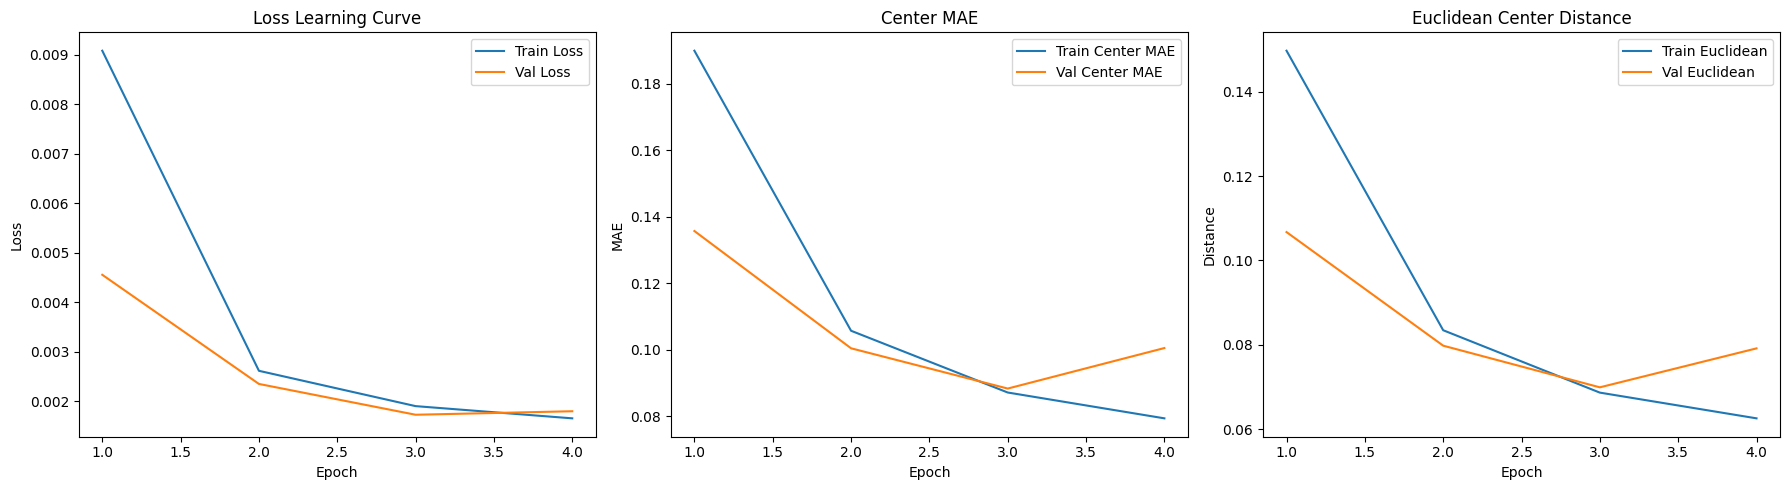

In [130]:
def plot_learning_curves(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.title('Loss Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    if 'center_mae_metric' in history.history:
        plt.plot(epochs, history.history['center_mae_metric'], label='Train Center MAE')
        plt.plot(epochs, history.history['val_center_mae_metric'], label='Val Center MAE')
        plt.title('Center MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Center MAE not available", horizontalalignment='center')
    
    plt.subplot(1, 3, 3)
    if 'euclidean_center_metric' in history.history:
        plt.plot(epochs, history.history['euclidean_center_metric'], label='Train Euclidean')
        plt.plot(epochs, history.history['val_euclidean_center_metric'], label='Val Euclidean')
        plt.title('Euclidean Center Distance')
        plt.xlabel('Epoch')
        plt.ylabel('Distance')
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Euclidean metric not available", horizontalalignment='center')
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

__Loss Curve__: Train Loss decreases significantly from the first epoch, and it continues to drop as the epochs progress. This indicates the model is learning and improving with each epoch.
Validation Loss also decreases but at a slower rate compared to the training loss. The gap between train and validation loss is minimal, suggesting that the model generalizes well and isn't overfitting.

__Center MAE (Mean Absolute Error)__: The Train Center MAE also decreases significantly, and it stabilizes around a small value as training progresses, indicating that the model is able to predict the pupil center more accurately.
The Validation Center MAE decreases similarly but with a slight fluctuation, meaning the model's performance on unseen data is relatively good, though not perfect. The gap between train and validation MAE remains small, indicating that the model isn’t overfitting.

__Euclidean Center Distance__: Train Euclidean Distance shows a strong improvement, starting from a higher value and rapidly converging to a lower distance, meaning the model is getting better at predicting the exact position of the pupil center.
Validation Euclidean Distance follows the same trend as the training data but with a slight delay. The model is performing well on validation data, and the gap between the two curves indicates generalization, though some fluctuations still exist.

## Iris Recognition

### Data preparation

In [63]:
def predict_missing_pupils(model, iris_data, pred_dataset_dir, image_size=(480,640), grid_size=(7,10), r_max=64):
    os.makedirs(pred_dataset_dir, exist_ok=True)
    
    grid_rows, grid_cols = grid_size
    img_h, img_w = image_size
    cell_h = img_h / grid_rows
    cell_w = img_w / grid_cols
    
    for idx, row in iris_data[iris_data['pupil_detected'] == 0].iterrows():
        orig_path = row["OriginalPath"]
        image = cv2.imread(orig_path)
        if image is None:
            print(f"Image not found: {orig_path}")
            continue
        
        image_resized = cv2.resize(image, (img_w, img_h))
        input_tensor = np.expand_dims(image_resized, axis=0)
        pred = model.predict(input_tensor, verbose=0)[0]
        
        confidence_map = pred[..., 3]
        cell_idx = np.unravel_index(np.argmax(confidence_map), confidence_map.shape)
        cell_row, cell_col = cell_idx
        
        x_offset, y_offset, r_scaled, conf = pred[cell_row, cell_col, :]
        
        pred_x = (cell_col + x_offset) * cell_w
        pred_y = (cell_row + y_offset) * cell_h
        pred_r = r_scaled * r_max
        
        iris_data.at[idx, 'pupil_x'] = pred_x
        iris_data.at[idx, 'pupil_y'] = pred_y
        iris_data.at[idx, 'pupil_radius'] = pred_r
        
        overlay_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        cv2.circle(overlay_image, (int(pred_x), int(pred_y)), int(pred_r), (0, 255, 0), 2)
        cv2.circle(overlay_image, (int(pred_x), int(pred_y)), 2, (255, 0, 0), 3)
        
        save_filename = os.path.basename(orig_path)
        save_path = os.path.join(pred_dataset_dir, save_filename)
        cv2.imwrite(save_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))
        
        iris_data.at[idx, 'PupilPath'] = save_path
    
    print("Images were predicted")
    return iris_data

## iris_data = predict_missing_pupils(pupil_model, iris_data, pred_dataset_dir=PUPIL_PRED_DATASET_DIR)

The function predicts the pupil positions for images without annotations (1047 images) using a pre-trained model. It utilizes 18,953 images with segmented pupils, which were used to train the model. The function loads and resizes the unannotated images, applies the trained model to predict the pupil’s position and size, and updates the dataset with the predicted values (x, y, radius). It then saves the images with the predicted pupils.

In [72]:
iris_data.head(4)

Unnamed: 0  Label                                          ImagePath  \
0           0  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
1           1  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
2           2  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   
3           3  437-R  /kaggle/input/casia-iris-thousand/CASIA-Iris-T...   

                                    OriginalPath  \
0  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg   
1  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg   
2  ./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg   
3  ./data/CASIA-Iris-Thousand/437\R\S5437R02.jpg   

                                 PupilPath    pupil_x    pupil_y pupil_radius  \
0  .//data/pupil_dataset_pred\S5437R06.jpg  354.87254  195.84486    30.555643   
1       .//data/pupil_dataset\S5437R09.jpg        308        168           38   
2       .//data/pupil_dataset\S5437R07.jpg        330        172           36   
3       .//data/pupil_dataset\S5437R02.jpg        336        246           32   

   pupil_detected  
0               0  
1               1  
2               1  
3               1

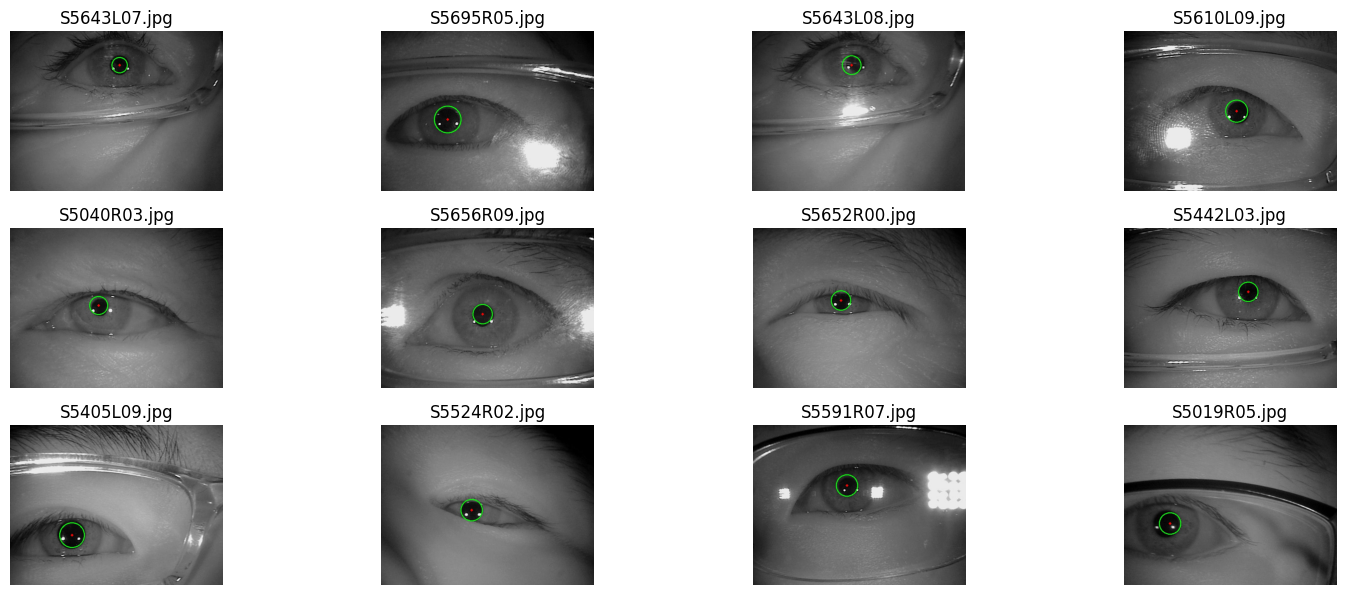

In [77]:
visualize_pupils(PUPIL_PRED_DATASET_DIR, random_images=12)

#### Crop Images

In [66]:
def crop_image(image, center_x, center_y, crop_width, crop_height):
    h, w = image.shape[:2]
    x1 = max(center_x - crop_width // 2, 0)
    y1 = max(center_y - crop_height // 2, 0)
    x2 = min(x1 + crop_width, w)
    y2 = min(y1 + crop_height, h)
    return image[y1:y2, x1:x2]

Based on the provided center coordinates (center_x, center_y) and the desired crop size (crop_width, crop_height). It ensures that the crop does not exceed the image boundaries by adjusting the coordinates accordingly. The function calculates the cropping area by determining the starting and ending points for both x and y axes and then returns the cropped region of the image.

In [67]:
def crop_verified_images(iris_data, save_dir, crop_width=240, crop_height=240):
    os.makedirs(save_dir, exist_ok=True)
    
    if "WorkPath" not in iris_data.columns:
        iris_data["WorkPath"] = ""
    
    for idx, row in iris_data.iterrows():
        orig_path = row["OriginalPath"]
        if pd.isnull(row["pupil_x"]) or pd.isnull(row["pupil_y"]):
            continue
        
        pupil_x = int(row["pupil_x"])
        pupil_y = int(row["pupil_y"])
        
        image = cv2.imread(orig_path)
        if image is None:
            continue
        
        cropped_image = crop_image(image, pupil_x, pupil_y, crop_width, crop_height)
        cropped_filename = os.path.basename(orig_path)
        cropped_path = os.path.join(save_dir, cropped_filename)
        cv2.imwrite(cropped_path, cropped_image)
        
        iris_data.at[idx, "WorkPath"] = cropped_path
    
    print(f"Processed {len(iris_data[iris_data['WorkPath'] != ''])} images. Cropped images saved in '{save_dir}'.")
    return iris_data

iris_data = crop_verified_images(iris_data, WORK_DATASET_DIR, crop_width=240, crop_height=240)

Processed 20000 images. Cropped images saved in './/data/work_dataset'.


It takes the image, crops it around the detected pupil, and saves the cropped images into the directory. The cropping area is defined by the given width and height (crop_width, crop_height), with default values set to 240x240. For each image, the function checks if the pupil coordinates are present, and if so, it crops and saves the image, updating the WorkPath column in iris_data with the new path of the cropped image.

In [70]:
iris_data.head(2)

Label                                   OriginalPath  \
0  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg   
1  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg   

                                 PupilPath    pupil_x    pupil_y  \
0  .//data/pupil_dataset_pred\S5437R06.jpg  354.87254  195.84486   
1       .//data/pupil_dataset\S5437R09.jpg  308.00000  168.00000   

   pupil_radius  pupil_detected                          WorkPath  
0     30.555643               0  ./data/work_dataset\S5437R06.jpg  
1     38.000000               1  ./data/work_dataset\S5437R09.jpg

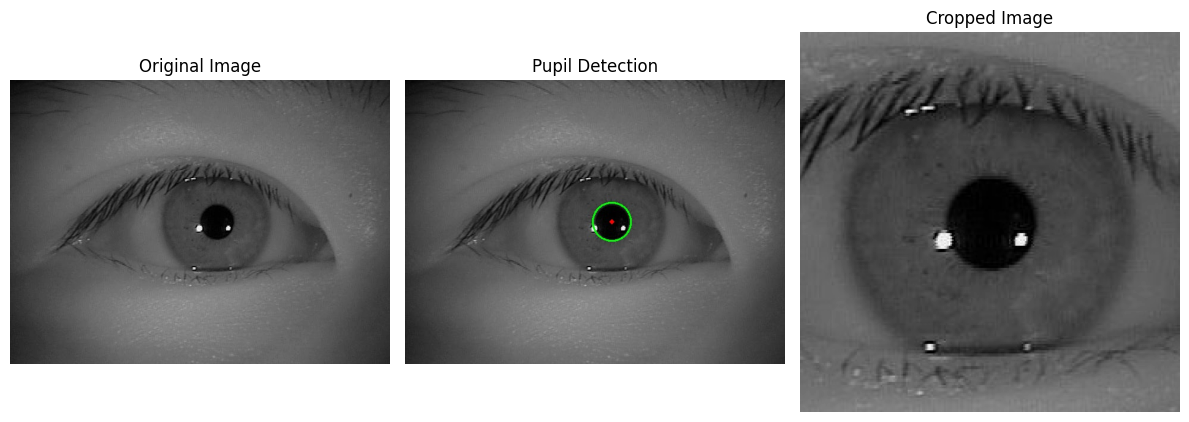

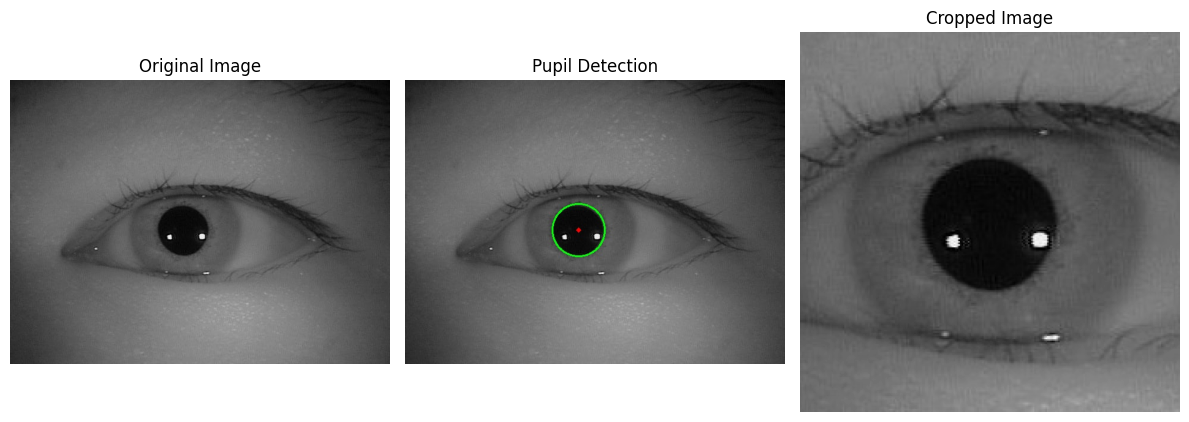

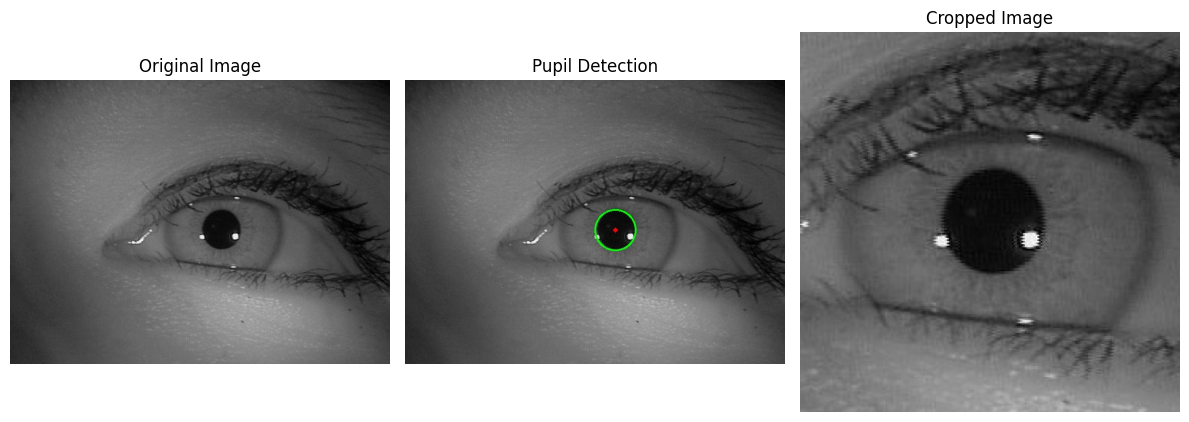

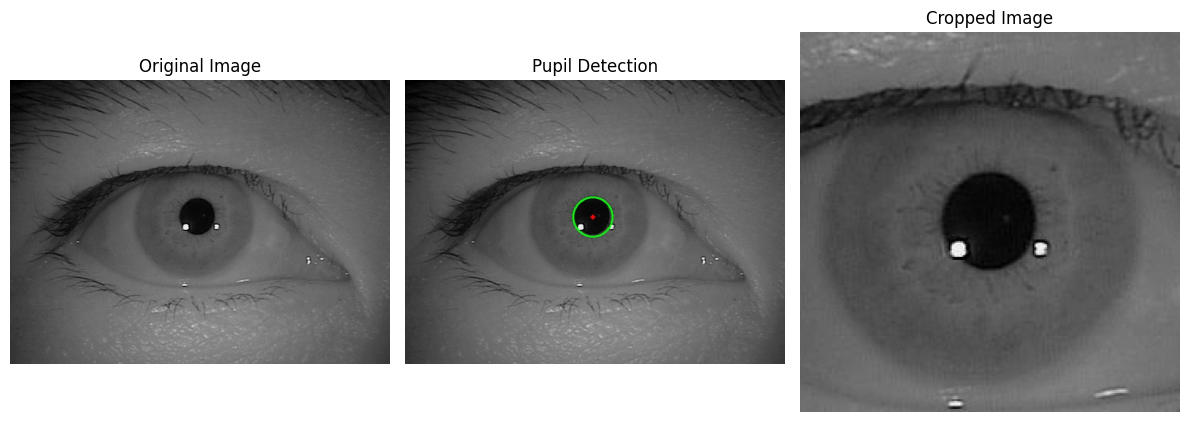

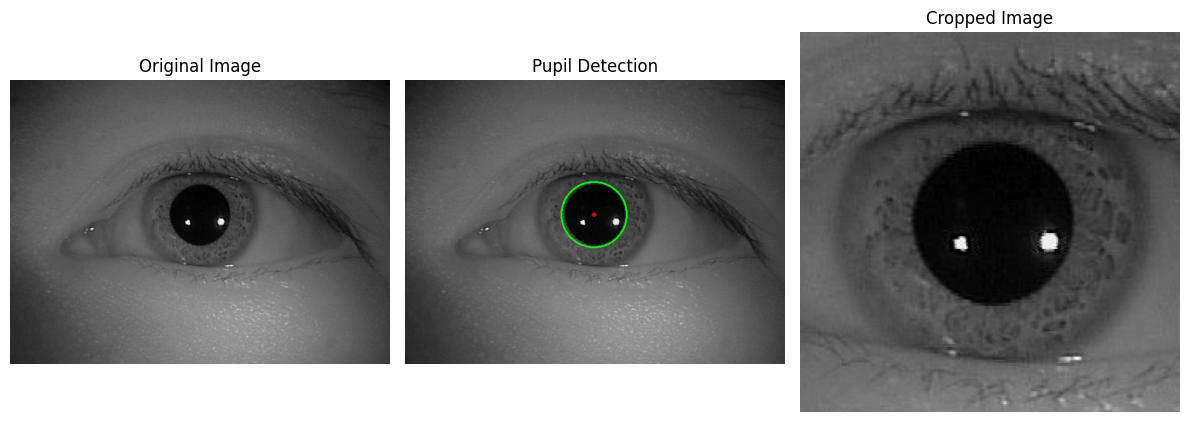

In [68]:
def visualize_random_rows(iris_data, random_images=5):
    sample_rows = iris_data.sample(n=random_images, random_state=42)
    
    for idx, row in sample_rows.iterrows():
        orig_path = row["OriginalPath"]
        pupil_path = row["PupilPath"]
        work_path = row["WorkPath"]
        
        original = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
        pupil_det = cv2.imread(pupil_path)
        pupil_det = cv2.cvtColor(pupil_det, cv2.COLOR_BGR2RGB)
        cropped = cv2.imread(work_path, cv2.IMREAD_GRAYSCALE)
        
        fig, ax = plt.subplots(1, 3, figsize=(12, 6))
        ax[0].imshow(original, cmap="gray")
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        
        ax[1].imshow(pupil_det)
        ax[1].set_title("Pupil Detection")
        ax[1].axis("off")
        
        ax[2].imshow(cropped, cmap="gray")
        ax[2].set_title("Cropped Image")
        ax[2].axis("off")
        
        plt.tight_layout()
        plt.show()

visualize_random_rows(iris_data, random_images=5)

#### Generate Masks

In [71]:
ORIGINAL_SIZE = (240, 240)
MODEL_SIZE = (320, 320)

def pad_image_to_square(image, pad_value=0):
    h, w = image.shape[:2]
    if h == w:
        return image
    new_size = max(h, w)
    top = (new_size - h) // 2
    bottom = new_size - h - top
    left = (new_size - w) // 2
    right = new_size - w - left
    padded = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=pad_value)
    return padded

The pad_image_to_square function adds padding to an image to make it square. It calculates the required padding for the shorter side and applies it evenly on all sides. If the image is already square, it returns it unchanged.

In [76]:
def preprocess_mask(image_path, target_size=MODEL_SIZE):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    
    h, w = img.shape[:2]
    if h != w:
        img = pad_image_to_square(img, pad_value=0)
    resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    resized = resized.astype(np.float32) / 255.0
    resized = np.expand_dims(resized, axis=-1)
    return resized

We read an image from the given path, converts it to grayscale, and pads it to a square if necessary. Then, it resizes the image to the target size (default is 320x320), normalizes the pixel values to the range [0, 1], and adds a channel dimension. It returns the processed mask ready for use in the model.

In [78]:
def _process_batch(batch_rows, model, iris_data):
    images = []
    for (idx, image_path, mask_save_path, pupil_r) in batch_rows:
        img = preprocess_mask(image_path, MODEL_SIZE)
        images.append(img)
    images = np.array(images)
    preds = model.predict(images, verbose=0)
    
    for i, (idx, image_path, mask_save_path, pupil_r) in enumerate(batch_rows):
        pred_mask = preds[i]

        pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
        if len(pred_mask.shape) == 3 and pred_mask.shape[2] == 1:
            pred_mask = pred_mask.squeeze(axis=-1)

        pred_mask_resized = cv2.resize(pred_mask, ORIGINAL_SIZE, interpolation=cv2.INTER_AREA)
        center_x = ORIGINAL_SIZE[0] // 2
        center_y = ORIGINAL_SIZE[1] // 2
        cv2.circle(pred_mask_resized, (center_x, center_y), int(pupil_r), 0, thickness=-1)
        cv2.imwrite(mask_save_path, pred_mask_resized)
        iris_data.at[idx, "MaskPath"] = mask_save_path

Preprocesses an image (resizes and normalizes it), then uses a model to predict the pupil mask. The mask is thresholded to create a binary image and resized to a target size. A circle is drawn on the mask, centered in the middle of the image, with a radius corresponding to the pupil_r parameter. The final mask is saved at the specified save_path.

In [79]:
def generate_all_masks(iris_data, save_mask_dir, model, batch_size=32):
    os.makedirs(save_mask_dir, exist_ok=True)
    
    if "MaskPath" not in iris_data.columns:
        iris_data["MaskPath"] = ""
    
    batch_rows = []
    for idx, row in iris_data.iterrows():
        image_path = row["WorkPath"]
        pupil_r = row["pupil_radius"]
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        mask_filename = base_name + ".jpg"
        mask_save_path = os.path.join(save_mask_dir, mask_filename)
        
        if os.path.exists(mask_save_path):
            iris_data.at[idx, "MaskPath"] = mask_save_path
            continue
        
        batch_rows.append((idx, image_path, mask_save_path, pupil_r))
        
        if len(batch_rows) >= batch_size:
            _process_batch(batch_rows, model, iris_data)
            batch_rows = []
    
    if batch_rows:
        _process_batch(batch_rows, model, iris_data)
    
    print(f"All masks saved in '{save_mask_dir}'")
    return iris_data

In [80]:
seg_model = tf.keras.models.load_model(SEG_MODEL, compile=False)
updated_iris_data = generate_all_masks(iris_data, MASK_DATASET_DIR, seg_model)

All masks saved in './data/mask_dataset/'


Processes all images in the provided iris_data DataFrame to create masks for each image __using the second segmentation model__(based on the paper), which is designed to segment the iris area. Before saving the generated mask, the function adds a black circle at the center, which represents the pupil, based on the pupil radius (pupil_r). The mask is then saved in the specified save_mask_dir, and the file path of the saved mask is added to the MaskPath column of the iris_data

In [81]:
iris_data.head(2)

Label                                   OriginalPath  \
0  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg   
1  437-R  ./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg   

                                 PupilPath    pupil_x    pupil_y  \
0  .//data/pupil_dataset_pred\S5437R06.jpg  354.87254  195.84486   
1       .//data/pupil_dataset\S5437R09.jpg  308.00000  168.00000   

   pupil_radius  pupil_detected                          WorkPath  \
0     30.555643               0  ./data/work_dataset\S5437R06.jpg   
1     38.000000               1  ./data/work_dataset\S5437R09.jpg   

                           MaskPath  
0  ./data/mask_dataset/S5437R06.jpg  
1  ./data/mask_dataset/S5437R09.jpg

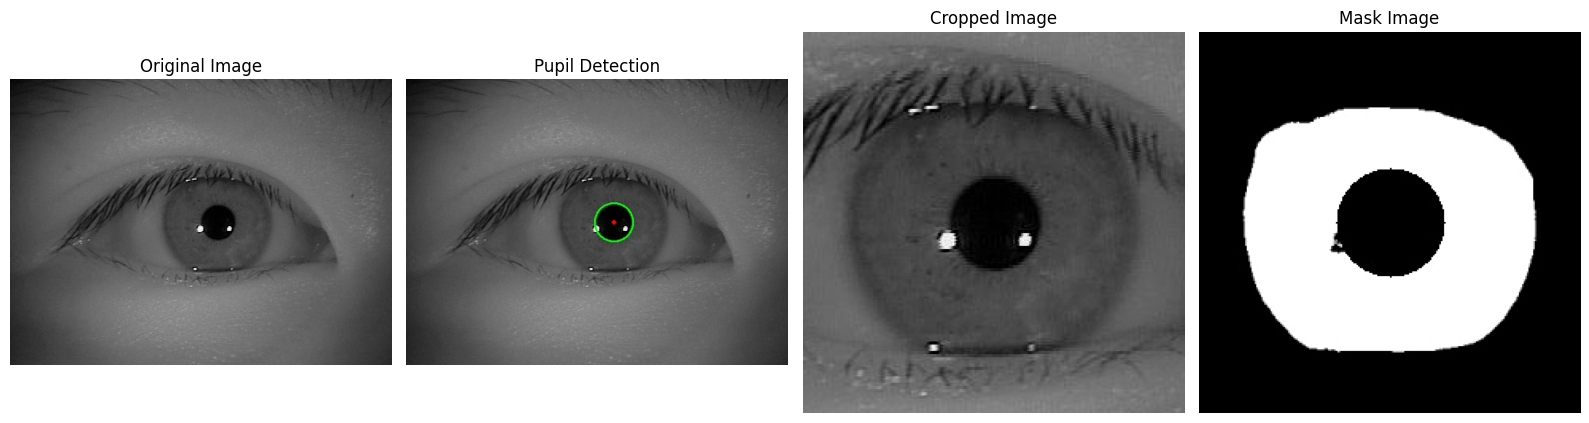

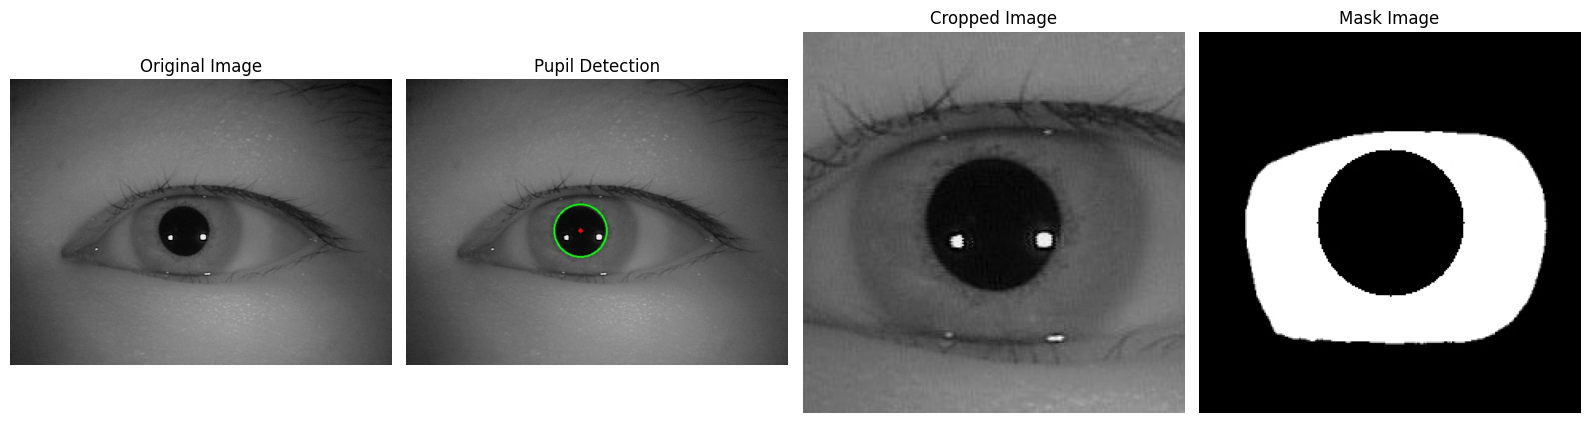

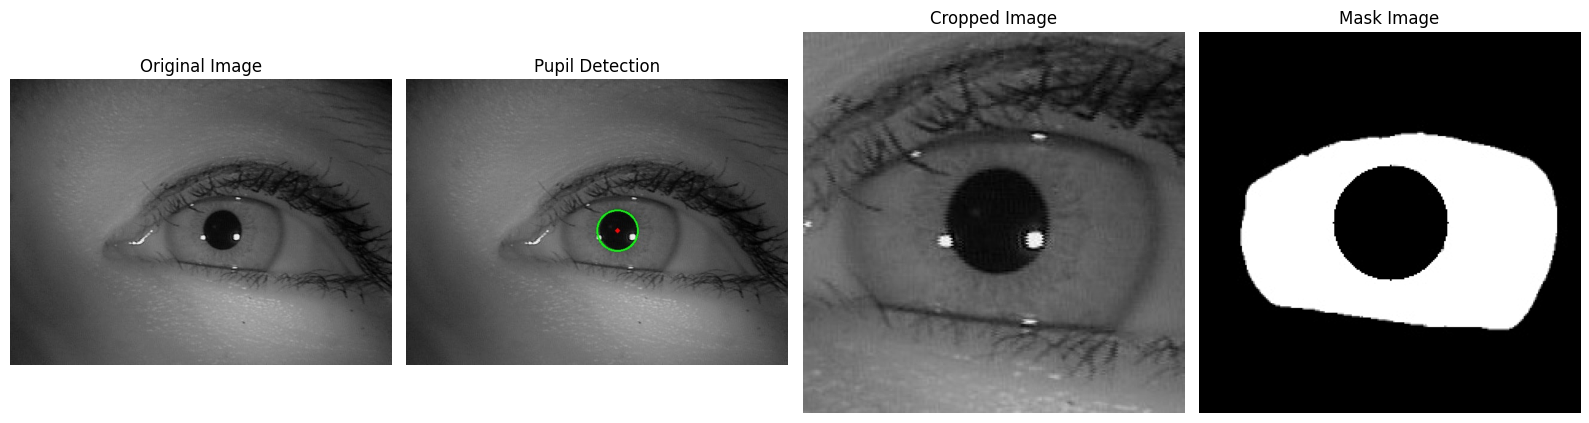

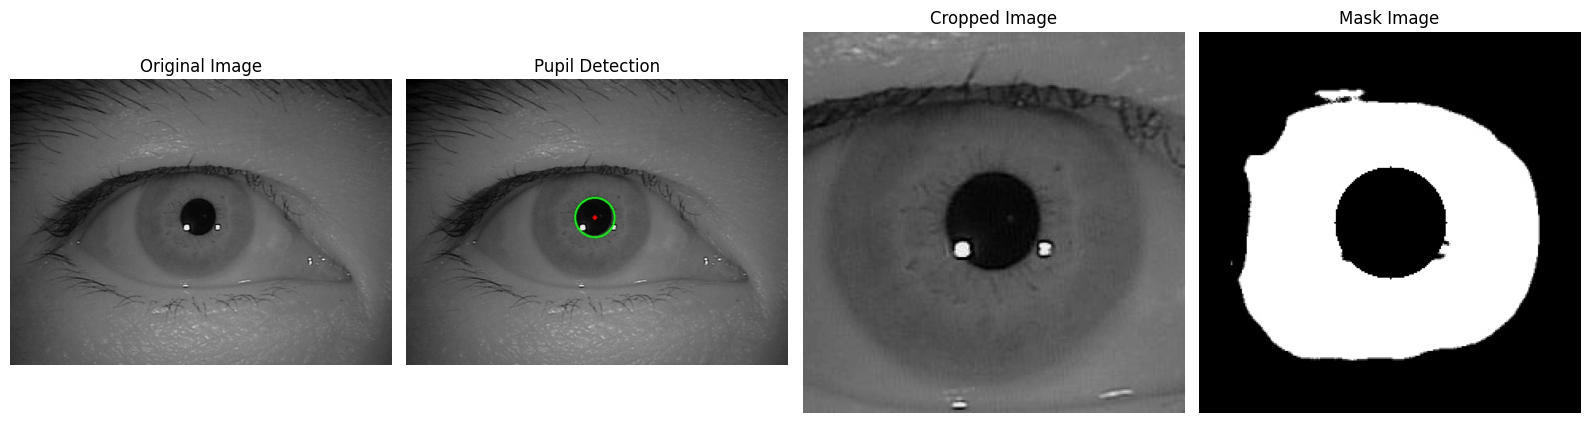

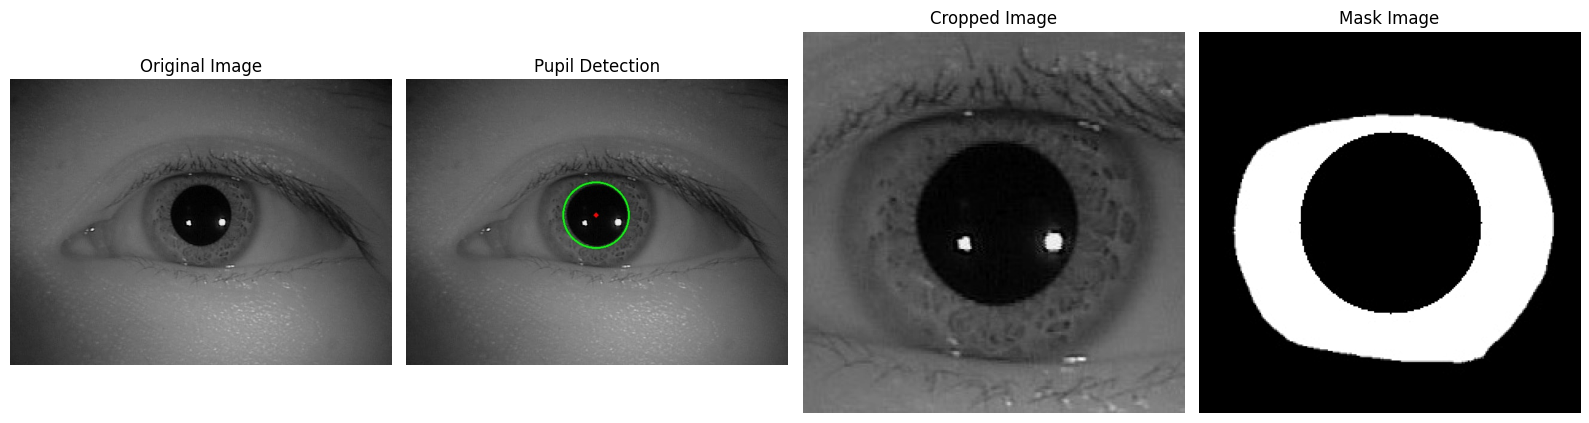

In [82]:
def visualize_random_mask_rows(iris_data, random_images=20):
    sample_rows = iris_data.sample(n=random_images, random_state=42)
    
    for idx, row in sample_rows.iterrows():
        orig_path = row["OriginalPath"]
        pupil_path = row["PupilPath"]
        work_path = row["WorkPath"]
        mask_path = row["MaskPath"]
        
        original = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
        pupil_det = cv2.imread(pupil_path)
        pupil_det = cv2.cvtColor(pupil_det, cv2.COLOR_BGR2RGB)
        cropped = cv2.imread(work_path, cv2.IMREAD_GRAYSCALE)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        fig, ax = plt.subplots(1, 4, figsize=(16, 6))
        
        ax[0].imshow(original, cmap="gray")
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        
        ax[1].imshow(pupil_det)
        ax[1].set_title("Pupil Detection")
        ax[1].axis("off")
        
        ax[2].imshow(cropped, cmap="gray")
        ax[2].set_title("Cropped Image")
        ax[2].axis("off")
        
        ax[3].imshow(mask_img, cmap="gray")
        ax[3].set_title("Mask Image")
        ax[3].axis("off")
        
        plt.tight_layout()
        plt.show()

visualize_random_mask_rows(iris_data, random_images=5)

After completing the first part (iris segmentation) and the second part (pupil detection), we successfully developed a method to centralize the irises within the image and crop unnecessary edges, effectively reducing unwanted noise. This step establishes a strong foundation for the final biometric identification process. Additionally, our masking model is designed to focus specifically on the iris area, excluding everything else from the image.

### Preprocessing

In [144]:
BATCH_RNN = 32
EPOCH_RNN = 32
SQUARE_RNN = 240

In [145]:
def remap_labels(iris_df):
    unique_labels = sorted(iris_df["Label"].astype(str).unique())
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    
    iris_df["MappedLabel"] = iris_df["Label"].map(label_mapping).astype(int)

    return iris_df, label_mapping

Mapping from each unique label to a unique integer index, then assigns the new integer-based labels to the MappedLabel column of the iris_data.

In [146]:
iris_data, label_mapping = remap_labels(iris_data)
for label, mapped in list(label_mapping.items())[:6]:
    print(f"'{label}': {mapped}")

'000-L': 0
'000-R': 1
'001-L': 2
'001-R': 3
'002-L': 4
'002-R': 5


In [147]:
def pad_to_square(image, target_size=(SQUARE_RNN, SQUARE_RNN)):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    if h == target_h and w == target_w:
        return image

    pad_top = max(0, (target_h - h) // 2)
    pad_bottom = max(0, target_h - h - pad_top)
    pad_left = max(0, (target_w - w) // 2)
    pad_right = max(0, target_w - w - pad_left)

    padded_image = cv2.copyMakeBorder(
        image, pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT, value=0
    )
    return padded_image

In the case where the image is cropped earlier and the pupil is near the edges, it could result in an image that is not exactly the desired shape. This function resolves that by padding 25 such images where necessary to achieve a consistent size of 240x240 pixels.

In [148]:
def stratified_split(df, label_col="MappedLabel", train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-8, "Not 1"

    train_rows, val_rows, test_rows = [], [], []
    random.seed(seed)

    unique_labels = df[label_col].unique()
    
    for label in unique_labels:
        label_df = df[df[label_col] == label]
        label_data = list(label_df.itertuples(index=False))
        random.shuffle(label_data)
        
        n = len(label_data)
        n_train = int(n * train_ratio)
        n_val   = int(n * val_ratio)
        
        train_part = label_data[:n_train]
        val_part   = label_data[n_train:n_train + n_val]
        test_part  = label_data[n_train + n_val:]
        
        train_rows.extend(train_part)
        val_rows.extend(val_part)
        test_rows.extend(test_part)
    
    train_df = pd.DataFrame(train_rows, columns=df.columns)
    val_df   = pd.DataFrame(val_rows,   columns=df.columns)
    test_df  = pd.DataFrame(test_rows,  columns=df.columns)
    return train_df, val_df, test_df

Dividing the dataset into training, validation, and test sets, while ensuring that the class distribution is maintained. With a total of 20,000 images and 2,000 classes, the function ensures that each subjec has 8 images for training, and 1 image each for validation and testing. This approach ensures that the data is split proportionally, maintaining a consistent distribution across all subsets.

In [149]:
train_df, val_df, test_df = stratified_split(iris_data, label_col="MappedLabel")
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 16000
Validation size: 2000
Test size: 2000


In [192]:
def create_dataset(iris_df, use_mask=False):
    X, Y = [], []
    img_col = "MaskPath" if use_mask else "WorkPath"

    for _, row in iris_df.iterrows():
        img_path = row[img_col]
        if not isinstance(img_path, str) or not os.path.exists(img_path):
            continue
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue
        
        image = pad_to_square(image, target_size=(SQUARE_RNN, SQUARE_RNN))
        image = image.astype(np.float32) / 255.0
        image = np.expand_dims(image, axis=-1)

        X.append(image)
        Y.append(row["MappedLabel"])

    if not X:
        raise ValueError("Error: No valid images found!")

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.int64)

Processesing images from the dataframe, either using masks or the original images based on the use_mask flag. It normalizes images and prepares them for training. The function returns the processed images and corresponding labels as NumPy arrays. If no valid images are found, an error is raised.

In [176]:
def augment_image(img):
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    if random.random() < 0.2:
        img_tensor = tf.image.flip_left_right(img_tensor)

    if random.random() < 0.2:
        img_tensor = tf.image.flip_up_down(img_tensor)

    if random.random() < 0.05:
        img_tensor = tf.image.random_brightness(img_tensor, max_delta=0.2)

    if random.random() < 0.1:
        img_tensor = tf.image.random_contrast(img_tensor, lower=0.8, upper=1.2)

    if random.random() < 0.1:
        img_tensor = tf.image.rot90(img_tensor, k=random.choice([1, 2, 3]))

    if random.random() < 0.1:
        scales = [0.8, 0.9, 1.1, 1.2]
        scale = random.choice(scales)
        img_shape = tf.shape(img_tensor)
        new_height = tf.cast(tf.cast(img_shape[0], tf.float32) * scale, tf.int32)
        new_width = tf.cast(tf.cast(img_shape[1], tf.float32) * scale, tf.int32)
        img_tensor = tf.image.resize(img_tensor, (new_height, new_width))
        img_tensor = tf.image.resize_with_crop_or_pad(img_tensor, img_shape[0], img_shape[1])

    if random.random() < 0.1:
        noise = tf.random.normal(shape=tf.shape(img_tensor), mean=0.0, stddev=0.05)
        img_tensor = img_tensor + noise
        img_tensor = tf.clip_by_value(img_tensor, 0.0, 1.0)

    if random.random() < 0.1:
        img_np = img_tensor.numpy()
        img_np = np.squeeze(img_np, axis=-1)
        ksize = random.choice([3, 5])
        img_np = cv2.GaussianBlur(img_np, (ksize, ksize), 0)
        img_np = np.expand_dims(img_np, axis=-1)
        img_tensor = tf.convert_to_tensor(img_np, dtype=tf.float32)

    return img_tensor.numpy()

The augment_image function applies random augmentations to input images to increase the diversity of the training data and reduce overfitting. It performs various transformations, such as flipping, adjusting brightness and contrast, rotating, scaling, adding noise, and applying Gaussian blur. These augmentations help the model generalize better by exposing it to different variations of the input images.

In [177]:
def generator(iris_df, use_mask=False, target_size=(SQUARE_RNN, SQUARE_RNN), batch_size=32, augment=False):
    img_col = "MaskPath" if use_mask else "WorkPath"
    rows = iris_df.to_dict('records')
    
    while True:
        random.shuffle(rows)
        batch_images = []
        batch_labels = []
        
        for row in rows:
            img_path = row[img_col]
            if not isinstance(img_path, str) or not os.path.exists(img_path):
                continue
            
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            
            image = pad_to_square(image, target_size=target_size)

            image = image.astype(np.float32) / 255.0
            image = np.expand_dims(image, axis=-1)

            if augment:
                image = augment_image(image)
            
            batch_images.append(image)
            batch_labels.append(row["MappedLabel"])
            
            if len(batch_images) == batch_size:
                yield np.array(batch_images, dtype=np.float32), np.array(batch_labels, dtype=np.int64)
                batch_images, batch_labels = [], []

In [178]:
train_gen_rnn = generator(train_df, use_mask=False, batch_size=BATCH_RNN, augment=True)
val_gen_rnn = generator(val_df, use_mask=False, batch_size=BATCH_RNN, augment=False)

The generator is yielding batches of images and their labels from df. It processes the images by padding, resizing, and normalizing them. The function returns batches of images and their corresponding labels for model training.

### ResNet Model

In [179]:
def early_stopping_callback():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    )

The early_stopping_callback function creates and returns an early stopping callback for training. It monitors the validation loss (val_loss) and stops training if no improvement is seen for 3 consecutive epochs, restoring the best weights observed during training.

In [180]:
def residual_block(inputs, filters, kernel_size=3, stride=1):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    
    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs
    
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

The __Residual block__ is commonly used in models like ResNet. The function performs two convolutional operations with batch normalization and ReLU activation. If the stride is not 1 or the input channel size differs from the desired output filters, a shortcut (skip connection) is applied by performing a 1x1 convolution to match dimensions. Finally, the output of the convolution block is added to the shortcut, and ReLU activation is applied to the sum. 

In [181]:
def resnet_classifier(input_shape=(SQUARE_RNN, SQUARE_RNN, 1), num_classes=2000):

    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (7,7), strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    
    x = residual_block(x, filters=64, kernel_size=3, stride=1)
    x = residual_block(x, filters=64, kernel_size=3, stride=1)
    
    x = residual_block(x, filters=128, kernel_size=3, stride=2)
    x = residual_block(x, filters=128, kernel_size=3, stride=1)
    
    x = residual_block(x, filters=256, kernel_size=3, stride=2)
    x = residual_block(x, filters=256, kernel_size=3, stride=1)
    
    x = residual_block(x, filters=512, kernel_size=3, stride=2)
    x = residual_block(x, filters=512, kernel_size=3, stride=1)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

The __ResNet architecture__ is a deep convolutional neural network designed for image classification. It uses residual connections to allow deeper networks to train effectively by solving the vanishing gradient problem.

__Initial Convolution and Pooling__: The network starts with a 7x7 convolution with 64 filters followed by batch normalization and ReLU activation. It is followed by a max-pooling layer to reduce spatial dimensions and highlight key features.

__Residual Blocks__: These blocks use skip connections to preserve information across layers:

_Block 1 (res1)_: 64 filters, two 3x3 convolutions, capturing basic features.

_Block 2 (res2)_: 128 filters, learning more complex patterns.

_Block 3 (res3)_: 256 filters, capturing higher-level features.

_Block 4 (res4)_: 512 filters, learning the most abstract features.

__Global Pooling and Classification__: After the residual blocks, global average pooling reduces the feature map to a fixed-size vector. This vector is then passed through a fully connected layer, with the number of neurons equal to the number of target classes (2000), followed by softmax activation.

Output Layer: The output layer applies softmax to the final features, converting them into class probabilities, with the highest probability corresponding to the predicted class.

In [157]:
model_rnn = resnet_classifier(input_shape=(SQUARE_RNN,SQUARE_RNN,1), num_classes=len(train_df["MappedLabel"].unique()))
model_rnn.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 conv2d_178 (Conv2D)         (None, 120, 120, 64)         3136      ['input_9[0][0]']             
                                                                                                  
 batch_normalization_178 (B  (None, 120, 120, 64)         256       ['conv2d_178[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_154 (ReLU)            (None, 120, 120, 64)         0         ['batch_normalization_17

In [158]:
steps_per_epoch_rnn = math.ceil(len(train_df) / BATCH_RNN)
validation_steps_rnn = math.ceil(len(val_df) / BATCH_RNN)

history_rnn = model_rnn.fit(
    train_gen_rnn,
    steps_per_epoch=steps_per_epoch_rnn,
    validation_data=val_gen_rnn,
    validation_steps=validation_steps_rnn,
    epochs=EPOCH_RNN,
    callbacks=[early_stopping_callback()]
)

Epoch 1/32
500/500 [==============================] - 998s 2s/step - loss: 7.6608 - accuracy: 6.2500e-05 - val_loss: 7.6019 - val_accuracy: 4.9603e-04
Epoch 2/32
500/500 [==============================] - 982s 2s/step - loss: 7.5367 - accuracy: 3.1250e-04 - val_loss: 9.6420 - val_accuracy: 0.0000e+00
Epoch 3/32
500/500 [==============================] - 979s 2s/step - loss: 7.3331 - accuracy: 6.2500e-04 - val_loss: 7.2412 - val_accuracy: 0.0015
Epoch 4/32
500/500 [==============================] - 979s 2s/step - loss: 7.1524 - accuracy: 0.0013 - val_loss: 7.2659 - val_accuracy: 9.9206e-04
Epoch 5/32
500/500 [==============================] - 979s 2s/step - loss: 6.9171 - accuracy: 0.0040 - val_loss: 7.1641 - val_accuracy: 0.0030
Epoch 6/32
500/500 [==============================] - 982s 2s/step - loss: 6.3595 - accuracy: 0.0119 - val_loss: 6.4558 - val_accuracy: 0.0179
Epoch 7/32
500/500 [==============================] - 986s 2s/step - loss: 5.4900 - accuracy: 0.0464 - val_loss: 6.365

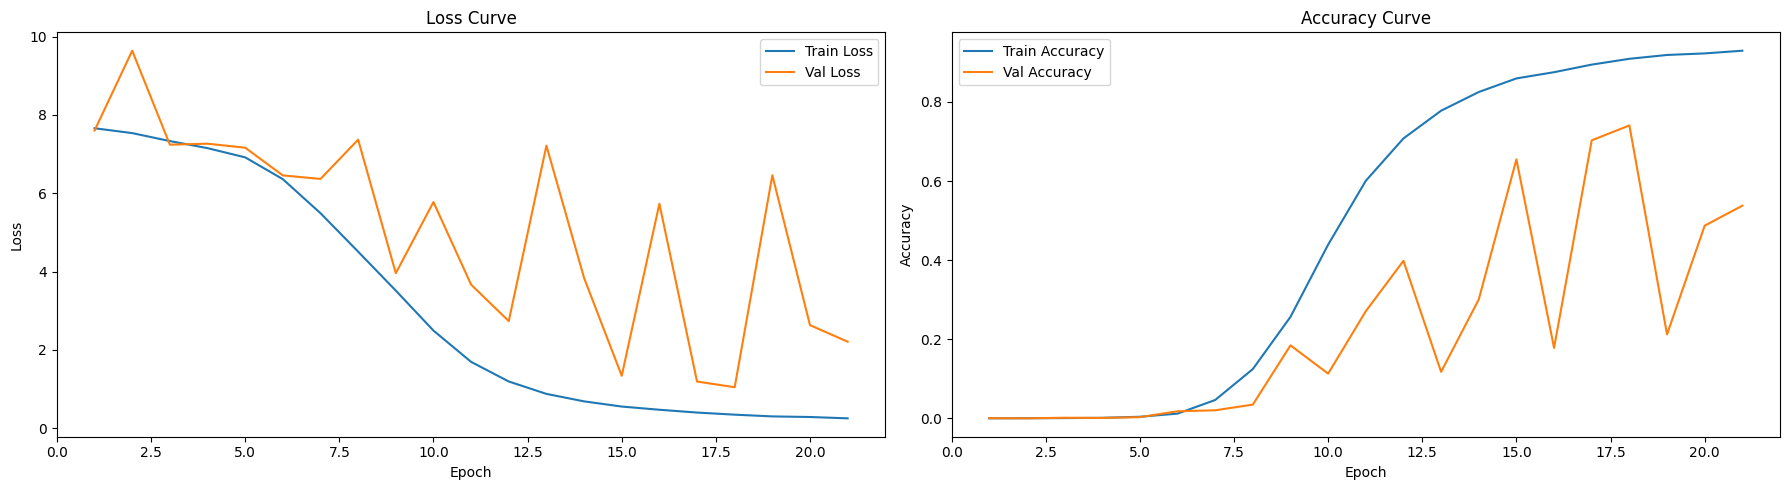

In [159]:
def plot_curves(history_rnn):
    epochs = range(1, len(history_rnn.history['loss']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_rnn.history['loss'], label='Train Loss')
    plt.plot(epochs, history_rnn.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_rnn.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history_rnn.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_curves(history_rnn)

__Training Loss vs. Validation Loss__:
While the training loss consistently decreases and stabilizes, the validation loss begins to increase after around epoch 5. This gap suggests the model is memorizing the training data, failing to generalize well to unseen validation data. This is a classic sign of overfitting.

__Training Accuracy vs. Validation Accuracy__:
The training accuracy shows a steady increase and levels off, which is expected as the model learns to map the input data to the correct outputs. However, the validation accuracy fluctuates and peaks around epoch 6-7, then starts to drop, showing that the model is not performing as well on unseen data. This decline in validation accuracy after a certain point reinforces the idea of overfitting.

In [160]:
def save_and_evaluate_model(model, X_test, Y_test, model_name, save_dir=SAVE_DIR):
    os.makedirs(save_dir, exist_ok=True)
    
    model_path = os.path.join(save_dir, f"{model_name}.h5")
    
    model.save(model_path)
    print(f"Model saved as {model_path}")
    
    loaded_model = tf.keras.models.load_model(model_path)
    print(f"Model {model_name} loaded for evaluation.")
    
    test_loss, test_accuracy = loaded_model.evaluate(X_test, Y_test, verbose=1)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    return test_loss, test_accuracy

X_test_rnn, Y_test_rnn = create_dataset(test_df, use_mask=False)
save_and_evaluate_model(model_rnn, X_test_rnn, Y_test_rnn, model_name="rec_model")

C:\Users\Gaming PC\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as ./data\rec_model.h5
Model rec_model loaded for evaluation.
63/63 [==============================] - 23s 347ms/step - loss: 1.0789 - accuracy: 0.7490
Test Loss: 1.0789, Test Accuracy: 0.7490


(1.0789085626602173, 0.7490000128746033)

The model performs decently, with a relatively high accuracy, but the loss sugsts that it may not be fully optimized or generalized for the task.  While 74.9% accuracy is acceptable in some cases, there might still be opportunities to further optimize the model to improve both the loss and accuracy.

63/63 [==============================] - 23s 351ms/step


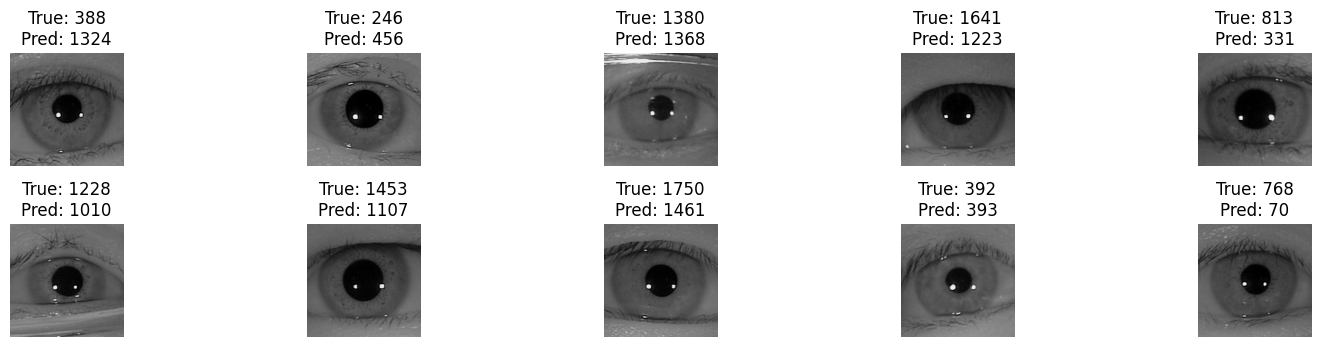

In [161]:
def plot_wrong_predictions(model, X_test, Y_test, class_names=None, num_samples=20):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    wrong_idx = np.where(y_pred != Y_test)[0]
    
    if len(wrong_idx) == 0:
        print("No misclassified samples found.")
        return
    
    selected_idx = np.random.choice(wrong_idx, min(num_samples, len(wrong_idx)), replace=False)
    
    plt.figure(figsize=(15, 7))
    for i, idx in enumerate(selected_idx):
        plt.subplot(4, 5, i+1)
        plt.imshow(np.squeeze(X_test[idx]), cmap='gray')
        true_label = Y_test[idx]
        pred_label = y_pred[idx]
        if class_names:
            true_label = class_names.get(true_label, true_label)
            pred_label = class_names.get(pred_label, pred_label)
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_wrong_predictions(model_rnn, X_test_rnn, Y_test_rnn, num_samples=10)

### ResNet Model with Mask

In [182]:
train_gen_mask = generator(train_df, use_mask=True, target_size=(SQUARE_RNN, SQUARE_RNN), batch_size=BATCH_RNN, augment=True)
val_gen_mask = generator(val_df, use_mask=True, target_size=(SQUARE_RNN, SQUARE_RNN), batch_size=BATCH_RNN, augment=False)

In [183]:
num_classes = len(train_df["MappedLabel"].unique())
model_mask = resnet_classifier(input_shape=(SQUARE_RNN, SQUARE_RNN, 1), num_classes=num_classes)
model_mask.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 conv2d_238 (Conv2D)         (None, 120, 120, 64)         3136      ['input_12[0][0]']            
                                                                                                  
 batch_normalization_238 (B  (None, 120, 120, 64)         256       ['conv2d_238[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_205 (ReLU)            (None, 120, 120, 64)         0         ['batch_normalization_23

In [184]:
steps_per_epoch_mask = math.ceil(len(train_df) / BATCH_RNN)
validation_steps_mask = math.ceil(len(val_df) / BATCH_RNN)

history_mask = model_mask.fit(
    train_gen_mask,
    steps_per_epoch=steps_per_epoch_mask,
    validation_data=val_gen_mask,
    validation_steps=validation_steps_mask,
    epochs=EPOCH_RNN,
    callbacks=[early_stopping_callback()]
)

Epoch 1/32
500/500 [==============================] - 1002s 2s/step - loss: 7.6719 - accuracy: 1.2500e-04 - val_loss: 7.6016 - val_accuracy: 4.9603e-04
Epoch 2/32
500/500 [==============================] - 978s 2s/step - loss: 7.6069 - accuracy: 2.5000e-04 - val_loss: 7.5993 - val_accuracy: 0.0000e+00
Epoch 3/32
500/500 [==============================] - 980s 2s/step - loss: 7.5937 - accuracy: 3.7500e-04 - val_loss: 7.5344 - val_accuracy: 4.9603e-04
Epoch 4/32
500/500 [==============================] - 979s 2s/step - loss: 7.4338 - accuracy: 8.7500e-04 - val_loss: 7.3238 - val_accuracy: 0.0020
Epoch 5/32
500/500 [==============================] - 980s 2s/step - loss: 7.1146 - accuracy: 0.0014 - val_loss: 7.0852 - val_accuracy: 0.0040
Epoch 6/32
500/500 [==============================] - 984s 2s/step - loss: 6.7172 - accuracy: 0.0044 - val_loss: 7.2353 - val_accuracy: 0.0050
Epoch 7/32
500/500 [==============================] - 978s 2s/step - loss: 6.2043 - accuracy: 0.0151 - val_loss: 

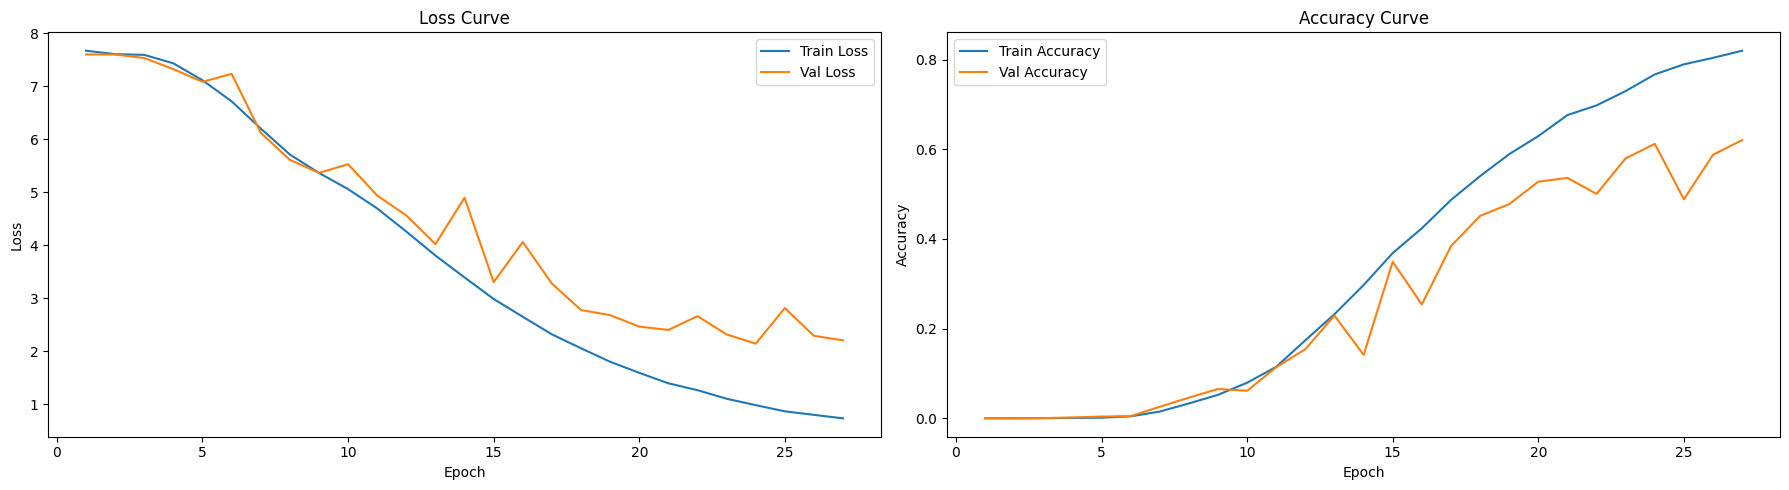

In [185]:
plot_curves(history_mask)

__Training Loss vs. Validation Loss__: The training loss decreases steadily, which indicates the model is effectively learning from the training data. However, the validation loss starts to increase after around epoch 5, suggesting that the model is overfitting. This means the model has learned the specifics of the training data but struggles to generalize to unseen data.

__Training Accuracy vs. Validation Accuracy__: The training accuracy increases steadily and stabilizes, which is typical as the model becomes more adept at recognizing patterns in the training data. On the other hand, the validation accuracy fluctuates, peaks around epochs 6-7, and then begins to drop. This decline in validation accuracy indicates that the model is overfitting to the training data, as it starts to perform worse on the validation set after a certain point.

In [191]:
X_test_mask, Y_test_mask = create_dataset(test_df, use_mask=True)
save_and_evaluate_model(model_mask, X_test_mask, Y_test_mask, model_name="rec_model_mask")

Model saved as ./data\rec_model_mask.h5
Model rec_model_mask loaded for evaluation.
63/63 [==============================] - 25s 389ms/step - loss: 2.1303 - accuracy: 0.6180
Test Loss: 2.1303, Test Accuracy: 0.6180


(2.1303467750549316, 0.6179999709129333)

63/63 [==============================] - 23s 361ms/step


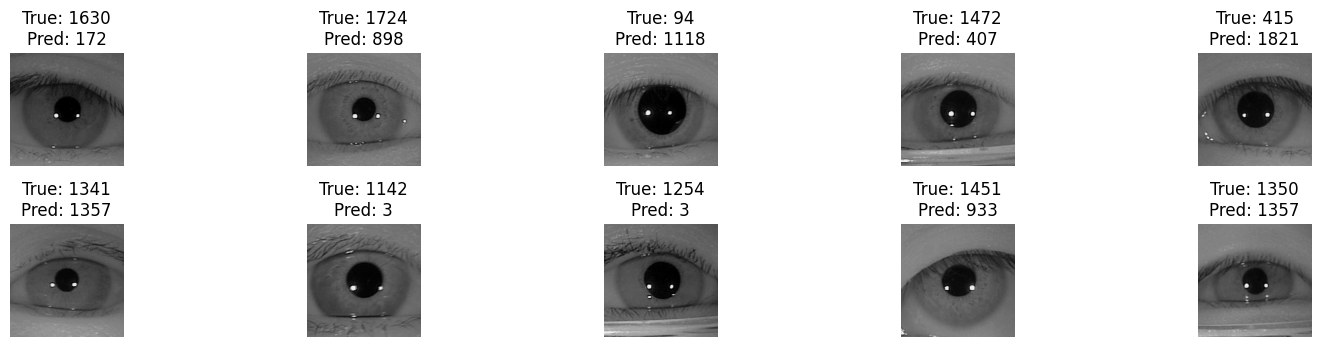

In [190]:
plot_wrong_predictions(model_mask, X_test_mask, Y_test_mask, num_samples=10)

## Conclusion

This project has successfully implemented an iris recognition system using deep learning techniques, particularly leveraging ResNet-based architectures for classification. Throughout the development, we refined preprocessing methods, optimized data augmentation strategies, and improved training pipelines to enhance the model’s performance.

While earlier stages showed promising results, the final phase encountered challenges related to overfitting and model generalization. Despite this, our work has laid a solid foundation for further improvements. In the coming iterations, we plan to incorporate stronger regularization techniques such as dropout tuning, weight decay, and advanced augmentation strategies to mitigate overfitting and improve model robustness.

This project remains open for further development, with potential enhancements in dataset expansion, architectural refinements, and real-world testing. With additional research and experimentation, we aim to push the boundaries of iris recognition accuracy and reliability.

Future work will focus on refining our approach to achieve a more stable and generalizable model.

## References

* [IIT Delhi Iris Database - Ajay Kumar and Arun Passi, "Comparison and combination of iris matchers for reliable personal authentication,” Pattern Recognition, vol. 43, no. 3, pp. 1016-1026, Mar. 2010.](https://www4.comp.polyu.edu.hk/~csajaykr/IITD/Database_Iris.htm)

* [CASIA Iris Database - Professor Tieniu Tan, Center for Biometrics and Security Research, National Laboratory of Pattern Recognition, Institute of Automation, Chinese Academy of Sciences](https://hycasia.github.io/dataset/casia-irisv4/)

* [U-Net: Convolutional Networks for Biomedical Image Segmentation, Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015 (MICCAI 2015)](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)

* [An integrated neural network model for pupil detection and tracking](https://link.springer.com/article/10.1007/s00500-021-05984-y)

* [Deep Residual Learning for Image Recognition by Kaiming He et al. (2015)](https://arxiv.org/pdf/1512.03385)

* [Deep Learning-Based Feature Extraction in Iris Recognition: Use Existing Models, Fine-tune or Train From Scratch?](https://arxiv.org/pdf/2002.08916)

* [Deep Learning for Iris Recognition: A Survey](https://arxiv.org/abs/1603.05027?utm_source=chatgpt.com)

* [Wide Residual Networks](https://arxiv.org/abs/1605.07146?utm_source=chatgpt.com)